#Description

This file contains code to implement all hybrid-2 models in the paper titled "Hybrid machine learning models using soft voting classifier for financial distress prediction". This paper was conditionally accepted at the Springer book titled "**Artificial Intelligence and Machine Learning for Econometrics: Applications, Regulation and Related Topics**". (forthcoming)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Outline

*   Part A: Data processing
* Part L. Logistic Regression (benchmark method)
* Part S: SVM
* Part R: Random Forests
* Part N: Neural Networks (for reference)
* Part X: XGBoost
* Part LG: LightGBM



**Necessary packages and libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import random
import os
from scipy import stats
import seaborn as sb

import sklearn
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from keras.models import Sequential
from keras.layers import Dense, Activation

from sklearn.utils import class_weight, compute_class_weight

In [ ]:
# Fix the random seed for reproducibility
seed = 2023

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
print("Numpy version " + np.__version__)
print('Sk-learn' + sklearn.__version__)

Numpy version 1.25.2
Sk-learn1.2.2


#VIF test

In [ ]:
df4 = pd.read_csv('/content/drive/MyDrive/Paper_Forecast_Financial_Distress/data/df_delist/df4.csv')

In [ ]:
# import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# the independent variables set
X_vif = df4[['wcapat', 'reat', 'mvdebt', 'saleat', 'size', 'ltat', 'OENEG', 'roa', 'INTWO', 'incgrowth', 'cfodebt']]

# VIF dataframe
vif0 = pd.DataFrame()
vif0["feature"] = X_vif.columns

# calculating VIF for each feature
vif0["VIF"] = [variance_inflation_factor(X_vif.values, i)
                          for i in range(len(X_vif.columns))]
# sort by VIF
vif0.sort_values(by = ['VIF'], ascending = False).head(20)

,feature,VIF
5,ltat,9.165697
4,size,9.007565
7,roa,3.675752
3,saleat,3.094722
1,reat,2.776000
10,cfodebt,2.487950
2,mvdebt,2.445802
0,wcapat,2.199500
6,OENEG,1.529044
8,INTWO,1.463322


**VIF test for Altman's variables**

In [ ]:
# the independent variables set
X_vif_Altman = df4[['wcapat', 'reat', 'ebitat', 'mvdebt', 'saleat']]

# VIF dataframe
vif0_Altman = pd.DataFrame()
vif0_Altman["feature"] = X_vif_Altman.columns

# calculating VIF for each feature
vif0_Altman["VIF"] = [variance_inflation_factor(X_vif_Altman.values, i)
                          for i in range(len(X_vif_Altman.columns))]
# sort by VIF
vif0_Altman.sort_values(by = ['VIF'], ascending = False).head(20)

,feature,VIF
2,ebitat,2.939588
4,saleat,2.188590
0,wcapat,1.883115
1,reat,1.728970
3,mvdebt,1.332180


**VIF test for Ohlson's variables**

In [ ]:
# the independent variables set
X_vif_Ohlson = df4[['roa', 'size', 'ltat', 'wcapat', 'lctact', 'OENEG', 'INTWO', 'incgrowth', 'cfodebt']]

# VIF dataframe
vif0_Ohlson = pd.DataFrame()
vif0_Ohlson["feature"] = X_vif_Ohlson.columns

# calculating VIF for each feature
vif0_Ohlson["VIF"] = [variance_inflation_factor(X_vif_Ohlson.values, i)
                          for i in range(len(X_vif_Ohlson.columns))]
# sort by VIF
vif0_Ohlson.sort_values(by = ['VIF'], ascending = False).head(20)

,feature,VIF
2,ltat,10.172913
4,lctact,9.788771
1,size,9.628928
3,wcapat,3.024405
0,roa,2.565220
6,INTWO,1.452519
8,cfodebt,1.444891
5,OENEG,1.409235
7,incgrowth,1.217701


**Normalize input variables**: Since the normally distributed assumption is not satistified, we might normalize/standardize the input variables.

In [ ]:
# Variables: X and y
X = df4[['wcapat', 'reat', 'ebitat', 'mvdebt', 'saleat']]
X1 = df4[['roa', 'size', 'ltat', 'wcapat', 'lctact', 'OENEG', 'INTWO', 'incgrowth', 'cfodebt']]
X2 = df4[['roa', 'reat', 'wcapat', 'mvdebt', 'saleat', 'size', 'ltat', 'OENEG', 'INTWO', 'incgrowth', 'cfodebt']]
y = df4.loc[:, df4.columns == 'bankrupt_period']

# Just for heat maps
all_variables_1 = df4[['bankrupt_period', 'wcapat', 'reat', 'ebitat', 'mvdebt', 'saleat']]
all_variables_2 = df4[['bankrupt_period', 'roa', 'size', 'ltat', 'wcapat', 'lctact', 'OENEG', 'INTWO', 'incgrowth', 'cfodebt']]
all_variables_3 = df4[['bankrupt_period', 'roa', 'reat', 'wcapat', 'mvdebt', 'saleat', 'size', 'ltat', 'OENEG', 'INTWO', 'incgrowth', 'cfodebt']]

**Correlation matrix**

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'bankrupt_period'),
  Text(0, 1.5, 'wcapat'),
  Text(0, 2.5, 'reat'),
  Text(0, 3.5, 'ebitat'),
  Text(0, 4.5, 'mvdebt'),
  Text(0, 5.5, 'saleat')])

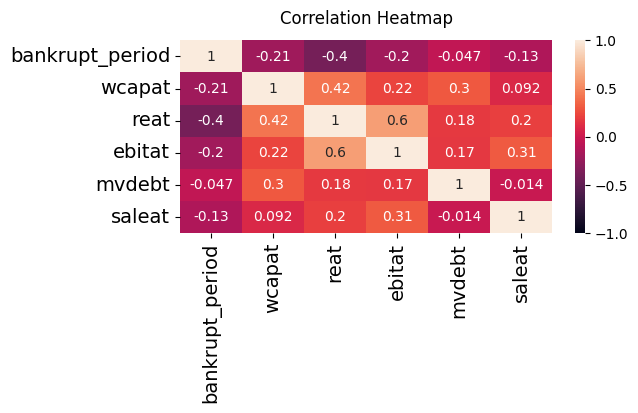

In [ ]:
# Altman's variables
plt.figure(figsize=(6, 2.5))
heatmap_Altman = sns.heatmap(all_variables_1.corr(), vmin=-1, vmax=1, annot=True)
heatmap_Altman.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'bankrupt_period'),
  Text(0, 1.5, 'roa'),
  Text(0, 2.5, 'size'),
  Text(0, 3.5, 'ltat'),
  Text(0, 4.5, 'wcapat'),
  Text(0, 5.5, 'lctact'),
  Text(0, 6.5, 'OENEG'),
  Text(0, 7.5, 'INTWO'),
  Text(0, 8.5, 'incgrowth'),
  Text(0, 9.5, 'cfodebt')])

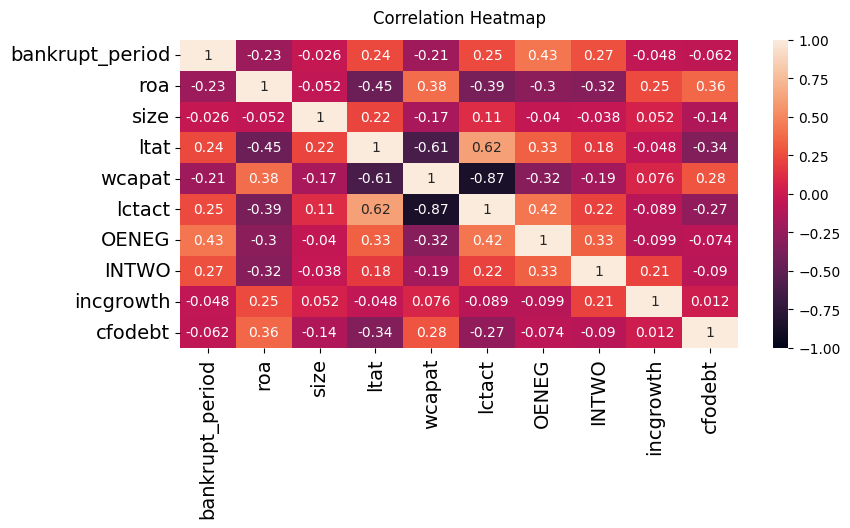

In [ ]:
# Altman's variables
plt.figure(figsize=(9, 4))
heatmap_Ohlson = sns.heatmap(all_variables_2.corr(), vmin=-1, vmax=1, annot=True)
heatmap_Ohlson.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, 'bankrupt_period'),
  Text(0, 1.5, 'roa'),
  Text(0, 2.5, 'reat'),
  Text(0, 3.5, 'wcapat'),
  Text(0, 4.5, 'mvdebt'),
  Text(0, 5.5, 'saleat'),
  Text(0, 6.5, 'size'),
  Text(0, 7.5, 'ltat'),
  Text(0, 8.5, 'OENEG'),
  Text(0, 9.5, 'INTWO'),
  Text(0, 10.5, 'incgrowth'),
  Text(0, 11.5, 'cfodebt')])

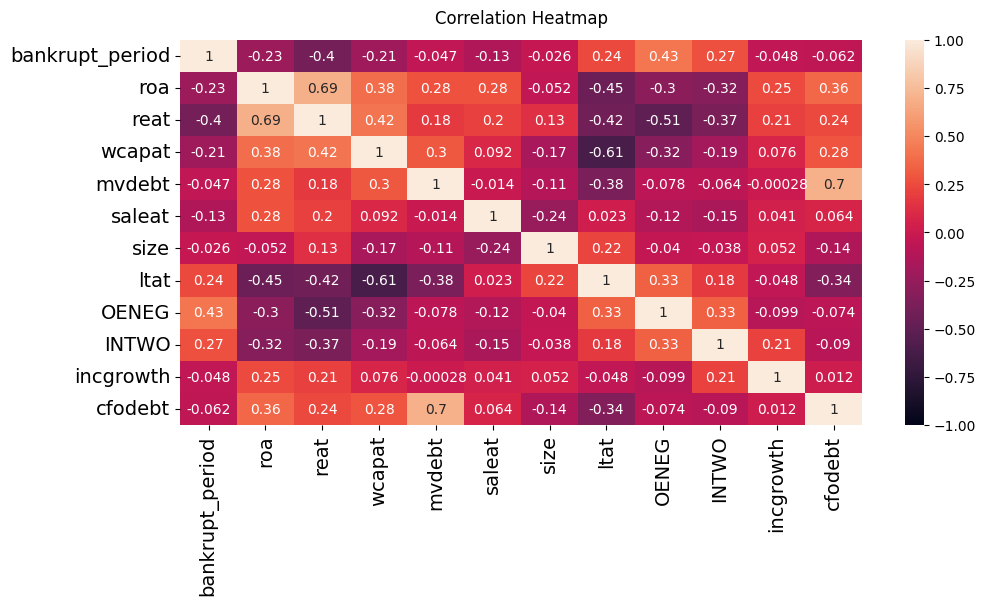

In [ ]:
# Altman's variables
plt.figure(figsize=(11, 5))
heatmap_Both = sns.heatmap(all_variables_3.corr(), vmin=-1, vmax=1, annot=True)
heatmap_Both.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

**Normalize variables**

In [ ]:
# Normalize X: x_norm = (x - x_min)/(x_max - x_min)
normalized_X = preprocessing.normalize(X)
print(normalized_X)

[[ 0.00802854  0.03486681  0.02919526  0.99484669  0.09026374]
 [ 0.01120487  0.04423741  0.06390756  0.98955061  0.12092528]
 [-0.01411781  0.04425696  0.05662276  0.9908623   0.11325975]
 ...
 [ 0.24235195  0.02527767  0.03603962  0.35391846  0.90225797]
 [ 0.20725875  0.03085304  0.02066287  0.34930826  0.91304364]
 [ 0.20461019  0.03289791  0.01735539  0.67480884  0.70808489]]


In [ ]:
# Normalize X1
normalized_X1 = preprocessing.normalize(X1)
print(normalized_X1)

[[ 0.00967226  0.99206736  0.05515585 ...  0.         -0.00525632
   0.03267384]
 [ 0.01137665  0.98919853  0.06711407 ...  0.          0.010001
   0.04850376]
 [ 0.00893369  0.97548215  0.08022977 ...  0.         -0.02328939
   0.0541627 ]
 ...
 [ 0.00525275  0.91701258  0.22067923 ...  0.          0.29940491
  -0.05201303]
 [ 0.01071682  0.961947    0.21714875 ...  0.          0.00549041
  -0.11075432]
 [ 0.01075688  0.97024815  0.15668035 ...  0.         -0.09432379
  -0.08066582]]


In [ ]:
# Normalize X2
normalized_X2 = preprocessing.normalize(X2)
print(normalized_X2)

[[ 0.00918149  0.01153377  0.0026558  ...  0.         -0.00498961
   0.03101598]
 [ 0.0110273   0.01205863  0.00305433 ...  0.          0.0096939
   0.04701433]
 [ 0.00877684  0.01188708 -0.00379194 ...  0.         -0.02288049
   0.05321174]
 ...
 [ 0.00512461  0.00646551  0.06198863 ...  0.          0.29210108
  -0.0507442 ]
 [ 0.00974688  0.01328422  0.08923823 ...  0.          0.00499349
  -0.10073031]
 [ 0.00933247  0.01681801  0.10460048 ...  0.         -0.08183355
  -0.06998415]]


In [ ]:
# Convert numpy.ndarray to pandas dataframe
X_norm = pd.DataFrame(normalized_X, columns = ['wcapat', 'reat', 'ebitat', 'mvdebt', 'saleat']) #5 variables
X1_norm = pd.DataFrame(normalized_X1, columns = ['roa', 'size', 'ltat', 'wcapat', 'lctact', 'OENEG', 'INTWO', 'incgrowth', 'cfodebt']) #9 vars
X2_norm = pd.DataFrame(normalized_X2, columns = ['roa', 'reat', 'wcapat', 'mvdebt', 'cfodebt', 'saleat', 'size', 'ltat', 'OENEG',  'INTWO', 'incgrowth']) #11 vars

# Check
X_norm

,wcapat,reat,ebitat,mvdebt,saleat
0,0.008029,0.034867,0.029195,0.994847,0.090264
1,0.011205,0.044237,0.063908,0.989551,0.120925
2,-0.014118,0.044257,0.056623,0.990862,0.113260
3,0.015586,0.032344,0.018095,0.997672,0.055079
4,0.041470,0.055721,0.057481,0.991645,0.092262
...,...,...,...,...,...
12680,0.154026,0.005482,0.059274,0.700301,0.694487
12681,0.069261,-0.039310,0.006148,0.589916,0.803504
12682,0.242352,0.025278,0.036040,0.353918,0.902258
12683,0.207259,0.030853,0.020663,0.349308,0.913044


#SINGLE MODELS

#Part L. Logistic regression

##L1. LR using SMOTE (Altman's variables)

In [ ]:
# Using SMOTE in imblearn for balancing data
from imblearn.over_sampling import SMOTE

# Split data into train and test set
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

# Oversampling train and test data using SMOTE
oversampling = SMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=42)
X_norm_train_smote, y_norm_train_smote = oversampling.fit_resample(X_norm_train, y_norm_train)

In [ ]:
# Model
logreg_smote = LogisticRegression()

In [ ]:
X_norm_train_smote

,wcapat,reat,ebitat,mvdebt,saleat
0,0.089373,-0.012826,0.032862,0.452949,0.886344
1,-0.196702,0.022069,0.075593,0.396149,0.893405
2,0.008656,0.002874,0.007912,0.999922,0.003054
3,0.001592,0.001399,0.001498,0.999937,0.010918
4,-0.269982,-0.382187,-0.051579,0.125841,0.873239
...,...,...,...,...,...
19463,-0.634490,-0.631022,-0.101280,0.307271,0.302696
19464,-0.543946,-0.770011,-0.103919,0.253539,0.190064
19465,-0.374375,-0.499961,-0.017404,0.299899,0.716021
19466,-0.543946,-0.770011,-0.103919,0.253539,0.190064


In [ ]:
y_norm_train_smote

,bankrupt_period
0,0
1,0
2,0
3,0
4,0
...,...
19463,1
19464,1
19465,1
19466,1


In [ ]:
logr1_smote = logreg_smote.fit(X_norm_train_smote, y_norm_train_smote.values.ravel())
print(logr1_smote.intercept_)
print(logr1_smote.coef_)

[1.88622169]
[[ 0.86696142 -9.84967032  2.13316022 -2.85818358 -1.51464521]]


In [ ]:
# Confusion matrix
confusion_matrix(y_norm_test, logr1_smote.predict(X_norm_test))

array([[2209,  211],
       [  38,   79]])

In [ ]:
# Normalize confusion matrix
confusion_matrix(y_norm_test, logr1_smote.predict(X_norm_test), normalize='true')

array([[0.91280992, 0.08719008],
       [0.32478632, 0.67521368]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y_norm_test, logr1_smote.predict(X_norm_test))

0.38760987225320986

In [ ]:
# Precision, recall, F1-score
print(classification_report(y_norm_test, logr1_smote.predict(X_norm_test)))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95      2420
           1       0.27      0.68      0.39       117

    accuracy                           0.90      2537
   macro avg       0.63      0.79      0.67      2537
weighted avg       0.95      0.90      0.92      2537



In [ ]:
print('Accuracy:', accuracy_score(y_norm_test, logr1_smote.predict(X_norm_test)))
print('Balanced accuracy:', balanced_accuracy_score(y_norm_test, logr1_smote.predict(X_norm_test)))

Accuracy: 0.9018525817895152
Balanced accuracy: 0.7940117962845236


**Feature important**

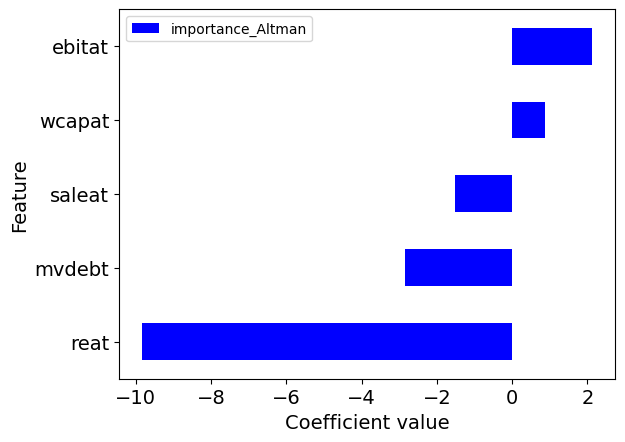

In [ ]:
feature_names_Altman = ['wcapat', 'reat', 'ebitat', 'mvdebt', 'saleat']
w_10 = logr1_smote.coef_[0]

feature_importance_Altman = pd.DataFrame(feature_names_Altman, columns = ["Feature"])
feature_importance_Altman["importance_Altman"] = pow(w_10, 1)
feature_importance_Altman = feature_importance_Altman.sort_values(by = ["importance_Altman"], ascending=True)

ax = feature_importance_Altman.plot.barh(x='Feature', y='importance_Altman', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coefficient value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

##L2. LR using SMOTE (Ohlson's variables)

In [ ]:
# Split data into train and test set
X1_norm_train, X1_norm_test, y1_norm_train, y1_norm_test = train_test_split(X1_norm, y, test_size=0.2, random_state=42)

# Oversampling train and test data using SMOTE
oversampling = SMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=42)
X1_norm_train_smote, y1_norm_train_smote = oversampling.fit_resample(X1_norm_train, y1_norm_train)

In [ ]:
logr2_smote = logreg_smote.fit(X1_norm_train_smote, y1_norm_train_smote.values.ravel())
print(logr2_smote.intercept_)
print(logr2_smote.coef_)

[1.40773171]
[[-6.71860523 -2.98953501 10.61086576 -9.74874584 -1.78731005  9.05230651
   8.07083161 -2.04786995 -1.33906554]]


In [ ]:
# Confusion matrix
confusion_matrix(y1_norm_test, logr2_smote.predict(X1_norm_test))

array([[2133,  287],
       [  31,   86]])

In [ ]:
# Normalize confusion matrix
confusion_matrix(y1_norm_test, logr2_smote.predict(X1_norm_test), normalize='true')

array([[0.88140496, 0.11859504],
       [0.26495726, 0.73504274]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y1_norm_test, logr2_smote.predict(X1_norm_test))

0.3651016552166601

In [ ]:
# Precision, recall, F1-score
print(classification_report(y1_norm_test, logr2_smote.predict(X1_norm_test)))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      2420
           1       0.23      0.74      0.35       117

    accuracy                           0.87      2537
   macro avg       0.61      0.81      0.64      2537
weighted avg       0.95      0.87      0.90      2537



In [ ]:
print('Accuracy:', accuracy_score(y1_norm_test, logr2_smote.predict(X1_norm_test)))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy:', balanced_accuracy_score(y1_norm_test, logr2_smote.predict(X1_norm_test)))

Accuracy: 0.8746551044540796
Balanced accuracy: 0.8082238468602105


**Feature importance**

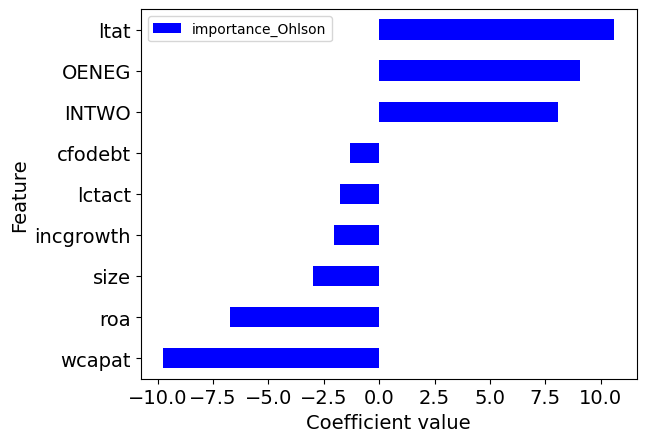

In [ ]:
feature_names_Ohlson = ['roa', 'size', 'ltat', 'wcapat', 'lctact', 'OENEG', 'INTWO', 'incgrowth', 'cfodebt']
w_20 = logr2_smote.coef_[0]

feature_importance_Ohlson = pd.DataFrame(feature_names_Ohlson, columns = ["Feature"])
feature_importance_Ohlson["importance_Ohlson"] = pow(w_20, 1)
feature_importance_Ohlson = feature_importance_Ohlson.sort_values(by = ["importance_Ohlson"], ascending=True)

ax = feature_importance_Ohlson.plot.barh(x='Feature', y='importance_Ohlson', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coefficient value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

##L3. LR using SMOTE (Altman and Ohlson's variables)

In [ ]:
# Split data into train and test set
X2_norm_train, X2_norm_test, y2_norm_train, y2_norm_test = train_test_split(X2_norm, y, test_size=0.2, random_state=42)

# Oversampling train and test data using SMOTE
oversampling = SMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=42)
X2_norm_train_smote, y2_norm_train_smote = oversampling.fit_resample(X2_norm_train, y2_norm_train)

In [ ]:
logr3_smote = logreg_smote.fit(X2_norm_train_smote, y2_norm_train_smote.values.ravel())
print(logr3_smote.intercept_)
print(logr3_smote.coef_)

[4.60814422]
[[  1.57933011 -26.35908452  -5.98172252  -4.55874139  -5.6276395
   -5.26837675   9.87743961   2.2191023    3.08021178   0.37825991
   -1.19476183]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Confusion matrix
confusion_matrix(y2_norm_test, logr3_smote.predict(X2_norm_test))

array([[2186,  234],
       [  17,  100]])

In [ ]:
# Normalize confusion matrix
confusion_matrix(y2_norm_test, logr3_smote.predict(X2_norm_test), normalize='true')

array([[0.90330579, 0.09669421],
       [0.14529915, 0.85470085]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y2_norm_test, logr3_smote.predict(X2_norm_test))

0.47021138661679196

In [ ]:
# Precision, recall, F1-score
print(classification_report(y2_norm_test, logr3_smote.predict(X2_norm_test)))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95      2420
           1       0.30      0.85      0.44       117

    accuracy                           0.90      2537
   macro avg       0.65      0.88      0.69      2537
weighted avg       0.96      0.90      0.92      2537



In [ ]:
print('Accuracy: ', accuracy_score(y2_norm_test, logr3_smote.predict(X2_norm_test)))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy: ', balanced_accuracy_score(y2_norm_test, logr3_smote.predict(X2_norm_test)))

Accuracy:  0.9010642491131258
Balanced accuracy:  0.8790033199124108


**Feature importance**

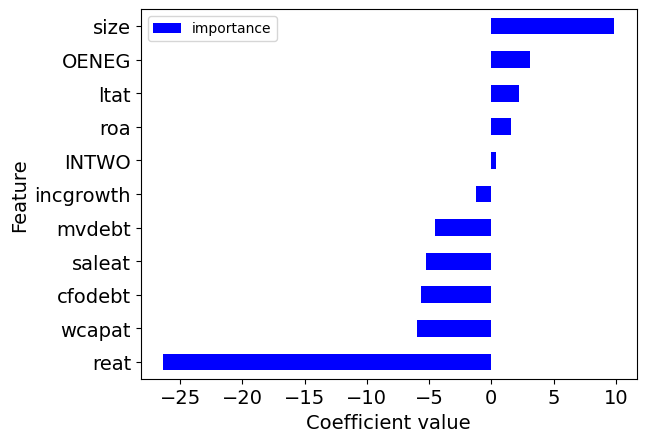

In [ ]:
feature_names_Both = ['roa', 'reat', 'wcapat', 'mvdebt', 'cfodebt', 'saleat', 'size', 'ltat', 'OENEG',  'INTWO', 'incgrowth']
w_30 = logr3_smote.coef_[0]

feature_importance_Both = pd.DataFrame(feature_names_Both, columns = ["Feature"])
feature_importance_Both['importance'] = pow(w_30, 1)
feature_importance_Both = feature_importance_Both.sort_values(by = ["importance"], ascending=True)

ax = feature_importance_Both.plot.barh(x='Feature', y='importance', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Coefficient value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

#Part S. Support Vector Machines (SVM)

##S1. SVM using SMOTE (Altman's variables)

In [ ]:
# Model
svc_smote = SVC(kernel='rbf')

In [ ]:
# Training
model_svc1_smote = svc_smote.fit(X_norm_train_smote, y_norm_train_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Predicting the classes for test set
y_norm_pred_svc1 = model_svc1_smote.predict(X_norm_test)

In [ ]:
# Confusion matrix
cm_svc1_smote = confusion_matrix(y_norm_test, y_norm_pred_svc1)
cm_svc1_smote

array([[2193,  227],
       [  22,   95]])

In [ ]:
# Normalize confusion matrix
cm_svc1_norm_smote = confusion_matrix(y_norm_test, y_norm_pred_svc1, normalize='true')
cm_svc1_norm_smote

array([[0.90619835, 0.09380165],
       [0.18803419, 0.81196581]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y_norm_test, y_norm_pred_svc1)

0.45249057748457927

In [ ]:
# Precision, recall, F1-score
print(classification_report(y_norm_test, y_norm_pred_svc1))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2420
           1       0.30      0.81      0.43       117

    accuracy                           0.90      2537
   macro avg       0.64      0.86      0.69      2537
weighted avg       0.96      0.90      0.92      2537



In [ ]:
print('Accuracy:', accuracy_score(y_norm_test, y_norm_pred_svc1))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy:', balanced_accuracy_score(y_norm_test, y_norm_pred_svc1))

Accuracy: 0.9018525817895152
Balanced accuracy: 0.859082079536625


##S2. SVM using SMOTE (Ohlson's variables)

In [ ]:
# fitting x samples and y classes
model_svc2_smote = svc_smote.fit(X1_norm_train_smote, y1_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_svc2 = model_svc2_smote.predict(X1_norm_test)

# Confusion matrix
cm_svc2_smote = confusion_matrix(y_norm_test, y_norm_pred_svc2)
cm_svc2_smote

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[2177,  243],
       [  32,   85]])

In [ ]:
# Normalize confusion matrix
cm_svc2_norm_smote = confusion_matrix(y1_norm_test, y_norm_pred_svc2, normalize='true')
cm_svc2_norm_smote

array([[0.89958678, 0.10041322],
       [0.27350427, 0.72649573]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y1_norm_test, y_norm_pred_svc2)

0.39137889355041966

In [ ]:
# Precision, recall, F1-score
print(classification_report(y1_norm_test, y_norm_pred_svc2))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2420
           1       0.26      0.73      0.38       117

    accuracy                           0.89      2537
   macro avg       0.62      0.81      0.66      2537
weighted avg       0.95      0.89      0.91      2537



In [ ]:
print('Accuracy: ', accuracy_score(y1_norm_test, y_norm_pred_svc2))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy', balanced_accuracy_score(y1_norm_test, y_norm_pred_svc2))

Accuracy:  0.8916042569964525
Balanced accuracy 0.8130412516776153


##S3. SVM using SMOTE (Altman and Ohlson's variables)

In [ ]:
# fitting x samples and y classes
model_svc3_smote = svc_smote.fit(X2_norm_train_smote, y2_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_svc3 = model_svc3_smote.predict(X2_norm_test)

# Confusion matrix
cm_svc3_smote = confusion_matrix(y_norm_test, y_norm_pred_svc3)
cm_svc3_smote

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[2177,  243],
       [  17,  100]])

In [ ]:
# Confusion matrix
cm_svc3_norm_smote = confusion_matrix(y2_norm_test, y_norm_pred_svc3, normalize='true')
cm_svc3_norm_smote

array([[0.89958678, 0.10041322],
       [0.14529915, 0.85470085]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y2_norm_test, y_norm_pred_svc3)

0.46267094638005174

In [ ]:
# Precision, recall, F1-score
print(classification_report(y2_norm_test, y_norm_pred_svc3))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2420
           1       0.29      0.85      0.43       117

    accuracy                           0.90      2537
   macro avg       0.64      0.88      0.69      2537
weighted avg       0.96      0.90      0.92      2537



In [ ]:
print('Accuracy: ', accuracy_score(y2_norm_test, y_norm_pred_svc3))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy:', balanced_accuracy_score(y2_norm_test, y_norm_pred_svc3))

Accuracy:  0.8975167520693733
Balanced accuracy: 0.8771438157801794


#Part R: Random Forests


**NOTE**: For robustness check and response to reviewers; Not report in the main results.

##R1. RF using SMOTE (Altman's variables)

In [ ]:
# Model
rf_smote = RandomForestClassifier(max_depth=2, random_state=0)

# Training
model_rf1_smote = rf_smote.fit(X_norm_train_smote, y_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_rf1 = model_rf1_smote.predict(X_norm_test)

# Confusion matrix
cm_rf1_smote = confusion_matrix(y_norm_test, y_norm_pred_rf1)
cm_rf1_smote

<ipython-input-63-c70c13a81b3f>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf1_smote = rf_smote.fit(X_norm_train_smote, y_norm_train_smote)


array([[2069,  351],
       [  27,   90]])

In [ ]:
# Normalize confusion matrix
cm_rf1_norm_smote = confusion_matrix(y_norm_test, y_norm_pred_rf1, normalize='true')
cm_rf1_norm_smote

array([[0.85495868, 0.14504132],
       [0.23076923, 0.76923077]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y_norm_test, y_norm_pred_rf1)

0.34546344680472585

In [ ]:
# Precision, recall, F1-score
print(classification_report(y_norm_test, y_norm_pred_rf1))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      2420
           1       0.20      0.77      0.32       117

    accuracy                           0.85      2537
   macro avg       0.60      0.81      0.62      2537
weighted avg       0.95      0.85      0.89      2537



In [ ]:
print('Accuracy:', accuracy_score(y_norm_test, y_norm_pred_rf1))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy:', balanced_accuracy_score(y_norm_test, y_norm_pred_rf1))

Accuracy: 0.8510051241623965
Balanced accuracy: 0.8120947234583599


##R2. RF using SMOTE (Ohlson's variables)

In [ ]:
# fitting x samples and y classes
model_rf2_smote = rf_smote.fit(X1_norm_train_smote, y1_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_rf2 = model_rf2_smote.predict(X1_norm_test)

# Confusion matrix
cm_rf2_smote = confusion_matrix(y_norm_test, y_norm_pred_rf2)
cm_rf2_smote

<ipython-input-68-ad297133a0cd>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf2_smote = rf_smote.fit(X1_norm_train_smote, y1_norm_train_smote)


array([[2156,  264],
       [  28,   89]])

In [ ]:
# Normalize confusion matrix
cm_rf2_norm_smote = confusion_matrix(y1_norm_test, y_norm_pred_rf2, normalize='true')
cm_rf2_norm_smote

array([[0.89090909, 0.10909091],
       [0.23931624, 0.76068376]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y1_norm_test, y_norm_pred_rf2)

0.39487828816767634

In [ ]:
# Precision, recall, F1-score
print(classification_report(y1_norm_test, y_norm_pred_rf2))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2420
           1       0.25      0.76      0.38       117

    accuracy                           0.88      2537
   macro avg       0.62      0.83      0.66      2537
weighted avg       0.95      0.88      0.91      2537



In [ ]:
print('Accuracy: ', accuracy_score(y1_norm_test, y_norm_pred_rf2))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy', balanced_accuracy_score(y1_norm_test, y_norm_pred_rf2))

Accuracy:  0.8849034292471423
Balanced accuracy 0.8257964257964258


##R3. RF using SMOTE (Altman and Ohlson's variables)

In [ ]:
# fitting x samples and y classes
model_rf3_smote = rf_smote.fit(X2_norm_train_smote, y2_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_rf3 = model_rf3_smote.predict(X2_norm_test)

# Confusion matrix
cm_rf3_smote = confusion_matrix(y_norm_test, y_norm_pred_rf3)
cm_rf3_smote

<ipython-input-73-7a3270be1c78>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf3_smote = rf_smote.fit(X2_norm_train_smote, y2_norm_train_smote)


array([[2082,  338],
       [  15,  102]])

In [ ]:
# Confusion matrix
cm_rf3_norm_smote = confusion_matrix(y2_norm_test, y_norm_pred_rf3, normalize='true')
cm_rf3_norm_smote

array([[0.86033058, 0.13966942],
       [0.12820513, 0.87179487]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y2_norm_test, y_norm_pred_rf3)

0.4055650895914771

In [ ]:
# Precision, recall, F1-score
print(classification_report(y2_norm_test, y_norm_pred_rf3))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      2420
           1       0.23      0.87      0.37       117

    accuracy                           0.86      2537
   macro avg       0.61      0.87      0.64      2537
weighted avg       0.96      0.86      0.90      2537



In [ ]:
print('Accuracy: ', accuracy_score(y2_norm_test, y_norm_pred_rf3))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy:', balanced_accuracy_score(y2_norm_test, y_norm_pred_rf3))

Accuracy:  0.8608592826172645
Balanced accuracy: 0.8660627251536342


#Part N. Neural networks

##N1. NN using SMOTE (Altman's variables)

In [ ]:
# Define the keras (the same as non-smote)
model_nn1_smote = Sequential()
model_nn1_smote.add(Dense(10, input_shape=(5,), activation='relu'))
model_nn1_smote.add(Dense(5, activation='relu'))
model_nn1_smote.add(Dense(5, activation='relu'))
model_nn1_smote.add(Dense(1, activation='sigmoid'))

# Model summary
model_nn1_smote.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 151 (604.00 Byte)
Trainable params: 151 (604.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# # Compile model
# model_nn1_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Fitting the model on the training data
# model_nn1_smote.fit(X_norm_train_smote, y_norm_train_smote, epochs=200, batch_size=32, verbose=1)

In [ ]:
# # Evaluate the keras model
# accuracy_nn1_smote = model_nn1_smote.evaluate(X_norm_test, y_norm_test)
# accuracy_nn1_smote

In [ ]:
# Predictions
predictions_nn1_smote = model_nn1_smote.predict(X_norm_test)
predictions_nn1_smote

80/80 [==============================] - 1s 2ms/step


array([[0.54371107],
       [0.5202141 ],
       [0.5443562 ],
       ...,
       [0.5413712 ],
       [0.54422534],
       [0.5443136 ]], dtype=float32)

In [ ]:
# Check
predictions_nn1_smote.max()

0.6188354

In [ ]:
# Check
predictions_nn1_smote.min()

0.5

In [ ]:
# Choose a threshold
y_norm_nn1_pred = (predictions_nn1_smote > 0.5)
y_norm_nn1_pred

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
# Confusion matrix
cm_nn1_smote = metrics.confusion_matrix(y_norm_test, y_norm_nn1_pred)
cm_nn1_smote

array([[ 127, 2293],
       [   0,  117]])

In [ ]:
# Normalize confusion matrix
cm_nn1_norm_smote = metrics.confusion_matrix(y_norm_test, y_norm_nn1_pred, normalize='true')
cm_nn1_norm_smote

array([[0.05247934, 0.94752066],
       [0.        , 1.        ]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y_norm_test, y_norm_nn1_pred)

0.05047526260159977

In [ ]:
# Precision, recall, F1-score
print(classification_report(y_norm_test, y_norm_nn1_pred))

              precision    recall  f1-score   support

           0       1.00      0.05      0.10      2420
           1       0.05      1.00      0.09       117

    accuracy                           0.10      2537
   macro avg       0.52      0.53      0.10      2537
weighted avg       0.96      0.10      0.10      2537



In [ ]:
print('Accuracy:', accuracy_score(y_norm_test, y_norm_nn1_pred))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy:', balanced_accuracy_score(y_norm_test, y_norm_nn1_pred))

Accuracy: 0.09617658651951123
Balanced accuracy: 0.5262396694214876


##N2. NN using SMOTE (Ohlson's variables)

In [ ]:
# Define the keras model (the same as non-smote)
model_nn2_smote = Sequential()
model_nn2_smote.add(Dense(18, input_shape=(9,), activation='relu'))
model_nn2_smote.add(Dense(9, activation='relu'))
model_nn2_smote.add(Dense(9, activation='relu'))
model_nn2_smote.add(Dense(1, activation='sigmoid'))

# Model summary
model_nn2_smote.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 18)                180       
                                                                 
 dense_5 (Dense)             (None, 9)                 171       
                                                                 
 dense_6 (Dense)             (None, 9)                 90        
                                                                 
 dense_7 (Dense)             (None, 1)                 10        
                                                                 
Total params: 451 (1.76 KB)
Trainable params: 451 (1.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# # Compile model
# model_nn2_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Fitting the model on the training data
# model_nn2_smote.fit(X1_norm_train_smote, y1_norm_train_smote, epochs=200, batch_size=32, verbose=1)

In [ ]:
# # Evaluate the keras model
# accuracy_nn2_smote = model_nn2_smote.evaluate(X1_norm_test, y1_norm_test)
# accuracy_nn2_smote

In [ ]:
# Predictions
predictions_nn2_smote = model_nn2_smote.predict(X1_norm_test)
predictions_nn2_smote

80/80 [==============================] - 0s 2ms/step


array([[0.49017084],
       [0.49096245],
       [0.48668274],
       ...,
       [0.49040312],
       [0.48971453],
       [0.50215137]], dtype=float32)

In [ ]:
predictions_nn2_smote.min()

0.4774595

In [ ]:
predictions_nn2_smote.max()

0.5068465

In [ ]:
# Choose a threshold
y_norm_nn2_pred = (predictions_nn2_smote > 0.5)
y_norm_nn2_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [ ]:
# Confusion matrix
cm_nn2_smote = metrics.confusion_matrix(y1_norm_test, y_norm_nn2_pred)
cm_nn2_smote

array([[2372,   48],
       [ 116,    1]])

In [ ]:
# Normalize confusion matrix
cm_nn2_norm_smote = metrics.confusion_matrix(y1_norm_test, y_norm_nn2_pred, normalize = 'true')
cm_nn2_norm_smote

array([[0.98016529, 0.01983471],
       [0.99145299, 0.00854701]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y1_norm_test, y_norm_nn2_pred)

-0.017202157859692542

In [ ]:
# Precision, recall, F1-score
print(classification_report(y1_norm_test, y_norm_nn2_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2420
           1       0.02      0.01      0.01       117

    accuracy                           0.94      2537
   macro avg       0.49      0.49      0.49      2537
weighted avg       0.91      0.94      0.92      2537



In [ ]:
print('Accuracy:', accuracy_score(y1_norm_test, y_norm_nn2_pred))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy:', balanced_accuracy_score(y1_norm_test, y_norm_nn2_pred))

Accuracy: 0.9353567205360662
Balanced accuracy: 0.49435614890160345


##N3. NN using SMOTE (Altman's and Ohlson's variables)

In [ ]:
# Define the keras model
model_nn3_smote = Sequential()
model_nn3_smote.add(Dense(22, input_shape=(11,), activation='relu'))
model_nn3_smote.add(Dense(11, activation='relu'))
model_nn3_smote.add(Dense(11, activation='relu'))
model_nn3_smote.add(Dense(1, activation='sigmoid'))

# Model summary
model_nn3_smote.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 22)                264       
                                                                 
 dense_9 (Dense)             (None, 11)                253       
                                                                 
 dense_10 (Dense)            (None, 11)                132       
                                                                 
 dense_11 (Dense)            (None, 1)                 12        
                                                                 
Total params: 661 (2.58 KB)
Trainable params: 661 (2.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# # Compile model
# model_nn3_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Fitting the model on the training data
# model_nn3_smote.fit(X2_norm_train_smote, y2_norm_train_smote, epochs=200, batch_size=32, verbose=1)

In [ ]:
# # Evaluate the keras model
# accuracy_nn3_smote = model_nn3_smote.evaluate(X2_norm_test, y2_norm_test)
# accuracy_nn3_smote

In [ ]:
# Predictions
predictions_nn3_smote = model_nn3_smote.predict(X2_norm_test)
predictions_nn3_smote

80/80 [==============================] - 0s 2ms/step


array([[0.4849474 ],
       [0.4824497 ],
       [0.48392943],
       ...,
       [0.4878689 ],
       [0.48681074],
       [0.48260832]], dtype=float32)

In [ ]:
predictions_nn3_smote.min()

0.4507605

In [ ]:
predictions_nn3_smote.max()

0.49766433

In [ ]:
# Choose a threshold
y_norm_nn3_pred = (predictions_nn3_smote > 0.5)
y_norm_nn3_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
# Confusion matrix
cm_nn3_smote = metrics.confusion_matrix(y2_norm_test, y_norm_nn3_pred)
cm_nn3_smote

array([[2420,    0],
       [ 117,    0]])

In [ ]:
# Normalize confusion matrix
cm_nn3_norm_smote = metrics.confusion_matrix(y2_norm_test, y_norm_nn3_pred, normalize='true')
cm_nn3_norm_smote

array([[1., 0.],
       [1., 0.]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y2_norm_test, y_norm_nn3_pred)

0.0

In [ ]:
# Precision, recall, F1-score
print(classification_report(y2_norm_test, y_norm_nn3_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2420
           1       0.00      0.00      0.00       117

    accuracy                           0.95      2537
   macro avg       0.48      0.50      0.49      2537
weighted avg       0.91      0.95      0.93      2537



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('Accuracy:', accuracy_score(y2_norm_test, y_norm_nn3_pred))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy:', balanced_accuracy_score(y2_norm_test, y_norm_nn3_pred))

Accuracy: 0.953882538431218
Balanced accuracy: 0.5


#Part X: XGBoost

In [ ]:
# Install
!pip install xgboost

In [ ]:
# Import
import xgboost as xgb

##X1. XGBoost using SMOTE (Altman's variables)

In [ ]:
# Model
#XGBoost_smote = SVC(kernel='rbf')
xgb_smote_1 = xgb.XGBClassifier()

# Training
model_XGBoost1_smote = xgb_smote_1.fit(X_norm_train_smote, y_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_XGBoost1 = model_XGBoost1_smote.predict(X_norm_test)

# Confusion matrix
cm_XGBoost1_smote = confusion_matrix(y_norm_test, y_norm_pred_XGBoost1) #fixed bug
cm_XGBoost1_smote

array([[2295,  125],
       [  30,   87]])

In [ ]:
# Normalize confusion matrix
cm_XGBoost1_norm_smote = confusion_matrix(y_norm_test, y_norm_pred_XGBoost1, normalize='true')
cm_XGBoost1_norm_smote

array([[0.94834711, 0.05165289],
       [0.25641026, 0.74358974]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y_norm_test, y_norm_pred_XGBoost1)

0.524430166689938

In [ ]:
# Precision, recall, F1-score
print(classification_report(y_norm_test, y_norm_pred_XGBoost1))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2420
           1       0.41      0.74      0.53       117

    accuracy                           0.94      2537
   macro avg       0.70      0.85      0.75      2537
weighted avg       0.96      0.94      0.95      2537



In [ ]:
print('Accuracy:', accuracy_score(y_norm_test, y_norm_pred_XGBoost1))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy:', balanced_accuracy_score(y_norm_test, y_norm_pred_XGBoost1))

Accuracy: 0.9389042175798187
Balanced accuracy: 0.8459684255138801


##X2. XGBoost using SMOTE (Ohlson's variables)

In [ ]:
# Model
xgb_smote_2 = xgb.XGBClassifier()

# fitting x samples and y classes
model_XGBoost2_smote = xgb_smote_2.fit(X1_norm_train_smote, y1_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_XGBoost2 = model_XGBoost2_smote.predict(X1_norm_test)

# Confusion matrix
cm_XGBoost2_smote = confusion_matrix(y_norm_test, y_norm_pred_XGBoost2)
cm_XGBoost2_smote

array([[2288,  132],
       [  36,   81]])

In [ ]:
# Normalize confusion matrix
cm_XGBoost2_norm_smote = confusion_matrix(y1_norm_test, y_norm_pred_XGBoost2, normalize='true')
cm_XGBoost2_norm_smote

array([[0.94545455, 0.05454545],
       [0.30769231, 0.69230769]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y1_norm_test, y_norm_pred_XGBoost2)

0.4823380809505656

In [ ]:
# Precision, recall, F1-score
print(classification_report(y1_norm_test, y_norm_pred_XGBoost2))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2420
           1       0.38      0.69      0.49       117

    accuracy                           0.93      2537
   macro avg       0.68      0.82      0.73      2537
weighted avg       0.96      0.93      0.94      2537



In [ ]:
print('Accuracy: ', accuracy_score(y1_norm_test, y_norm_pred_XGBoost2))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy', balanced_accuracy_score(y1_norm_test, y_norm_pred_XGBoost2))

Accuracy:  0.9337800551832873
Balanced accuracy 0.8188811188811189


##X3. XGBoost using SMOTE (Altman's and Ohlson's variables)

In [ ]:
# Model 3
xgb_smote_3 = xgb.XGBClassifier()

# fitting x samples and y classes
model_XGBoost3_smote = xgb_smote_3.fit(X2_norm_train_smote, y2_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_XGBoost3 = model_XGBoost3_smote.predict(X2_norm_test)

# Confusion matrix
cm_XGBoost3_smote = confusion_matrix(y_norm_test, y_norm_pred_XGBoost3)
cm_XGBoost3_smote

array([[2348,   72],
       [  24,   93]])

In [ ]:
# Confusion matrix
cm_XGBoost3_norm_smote = confusion_matrix(y2_norm_test, y_norm_pred_XGBoost3, normalize='true')
cm_XGBoost3_norm_smote

array([[0.97024793, 0.02975207],
       [0.20512821, 0.79487179]])

In [ ]:
# Matthews correlation coefficient (MCC)
matthews_corrcoef(y2_norm_test, y_norm_pred_XGBoost3)

0.6507747588070744

In [ ]:
# Precision, recall, F1-score
print(classification_report(y2_norm_test, y_norm_pred_XGBoost3))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2420
           1       0.56      0.79      0.66       117

    accuracy                           0.96      2537
   macro avg       0.78      0.88      0.82      2537
weighted avg       0.97      0.96      0.97      2537



In [ ]:
print('Accuracy: ', accuracy_score(y2_norm_test, y_norm_pred_XGBoost3))

# Balanced accuracy score: Average of recall for two seperate groups
print('Balanced accuracy:', balanced_accuracy_score(y2_norm_test, y_norm_pred_XGBoost3))

Accuracy:  0.9621600315333071
Balanced accuracy: 0.8825598643780461


### **Part LG: Light GBM**

In [ ]:
# Install
!pip install lightgbm

# Import LightGBM
import lightgbm as lgb

### **LG1. LightGBM using SMOTE (Altman's variables)**

In [ ]:
# Model
lgbm_smote_1 = lgb.LGBMClassifier()

# Training
model_LightGBM1_smote = lgbm_smote_1.fit(X_norm_train_smote, y_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_LightGBM1 = model_LightGBM1_smote.predict(X_norm_test)

# Confusion matrix
cm_LightGBM1_smote = confusion_matrix(y_norm_test, y_norm_pred_LightGBM1)
cm_LightGBM1_smote

# Normalize confusion matrix
cm_LightGBM1_norm_smote = confusion_matrix(y_norm_test, y_norm_pred_LightGBM1, normalize='true')
cm_LightGBM1_norm_smote

# Matthews correlation coefficient (MCC)
matthews_corrcoef(y_norm_test, y_norm_pred_LightGBM1)

# Precision, recall, F1-score
print(classification_report(y_norm_test, y_norm_pred_LightGBM1))
print('Accuracy:', accuracy_score(y_norm_test, y_norm_pred_LightGBM1))

# Balanced accuracy score: Average of recall for two separate groups
print('Balanced accuracy:', balanced_accuracy_score(y_norm_test, y_norm_pred_LightGBM1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 9734, number of negative: 9734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 19468, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2420
           1       0.36      0.79      0.49       117

    accuracy                           0.93      2537
   macro avg       0.67      0.86      0.73      2537
weighted avg       0.96      0.93      0.94      2537

Accuracy: 0.9251083957430035
Balanced accuracy: 0.8631383767747404


### **LG2. LightGBM using SMOTE (Ohlson's variables)**

In [ ]:
# Model
lgbm_smote_2 = lgb.LGBMClassifier()

# fitting x samples and y classes
model_LightGBM2_smote = lgbm_smote_2.fit(X1_norm_train_smote, y1_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_LightGBM2 = model_LightGBM2_smote.predict(X1_norm_test)

# Confusion matrix
cm_LightGBM2_smote = confusion_matrix(y1_norm_test, y_norm_pred_LightGBM2)
cm_LightGBM2_smote

# Normalize confusion matrix
cm_LightGBM2_norm_smote = confusion_matrix(y1_norm_test, y_norm_pred_LightGBM2, normalize='true')
cm_LightGBM2_norm_smote

# Matthews correlation coefficient (MCC)
matthews_corrcoef(y1_norm_test, y_norm_pred_LightGBM2)

# Precision, recall, F1-score
print(classification_report(y1_norm_test, y_norm_pred_LightGBM2))
print('Accuracy: ', accuracy_score(y1_norm_test, y_norm_pred_LightGBM2))

# Balanced accuracy score: Average of recall for two separate groups
print('Balanced accuracy', balanced_accuracy_score(y1_norm_test, y_norm_pred_LightGBM2))


[LightGBM] [Info] Number of positive: 9734, number of negative: 9734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 19468, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2420
           1       0.35      0.73      0.47       117

    accuracy                           0.93      2537
   macro avg       0.67      0.83      0.72      2537
weighted avg       0.96      0.93      0.94      2537

Accuracy:  0.9255025620811983
Balanced accuracy 0.8308098467189375


### **LG3. LightGBM using SMOTE (Altman's and Ohlson's variables)**

In [ ]:
# Model 3
lgbm_smote_3 = lgb.LGBMClassifier()

# fitting x samples and y classes
model_LightGBM3_smote = lgbm_smote_3.fit(X2_norm_train_smote, y2_norm_train_smote)

# Predicting the classes for test set
y_norm_pred_LightGBM3 = model_LightGBM3_smote.predict(X2_norm_test)

# Confusion matrix
cm_LightGBM3_smote = confusion_matrix(y2_norm_test, y_norm_pred_LightGBM3)
cm_LightGBM3_smote

# Normalize confusion matrix
cm_LightGBM3_norm_smote = confusion_matrix(y2_norm_test, y_norm_pred_LightGBM3, normalize='true')
cm_LightGBM3_norm_smote

# Matthews correlation coefficient (MCC)
matthews_corrcoef(y2_norm_test, y_norm_pred_LightGBM3)

# Precision, recall, F1-score
print(classification_report(y2_norm_test, y_norm_pred_LightGBM3))
print('Accuracy: ', accuracy_score(y2_norm_test, y_norm_pred_LightGBM3))

# Balanced accuracy score: Average of recall for two separate groups
print('Balanced accuracy:', balanced_accuracy_score(y2_norm_test, y_norm_pred_LightGBM3))


[LightGBM] [Info] Number of positive: 9734, number of negative: 9734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 19468, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2420
           1       0.53      0.81      0.64       117

    accuracy                           0.96      2537
   macro avg       0.76      0.89      0.81      2537
weighted avg       0.97      0.96      0.96      2537

Accuracy:  0.9582183681513599
Balanced accuracy: 0.8886275340820795


#HYBRID MODELS

**Repare the func for result visualing**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

name_voting = []
acc_voting = []

def visua_evaluate_model(model, X_train, y_train, X_test, y_test, conf_matrix=False, model_name = " "):
    best_accuracy = 0
    best_model = None

    for epoch in tqdm(range(2), desc="Training"):
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_test)

        accuracy_train = accuracy_score(y_test, y_pred_train)

        if accuracy_train > best_accuracy:
            best_accuracy = accuracy_train
            best_model = copy.deepcopy(model)

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    name_voting.append(model_name)
    acc_voting.append(accuracy)
    print(f'Accuracy: {accuracy:.3f}')
    print(f"Precision: {precision:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"Recall: {recall:.3f}")
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision, recall, f1]

    if conf_matrix:
        cnf_matrix = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")

        plt.figure(figsize=(8, 6))
        sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        report_rf = classification_report(y_test, y_pred)
        print(report_rf)

        plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
        plt.ylim(0, 1.1)
        plt.title(f'Model Evaluation Metrics - {str(model_name)}')
        plt.ylabel('Score')

        for i in range(len(metrics)):
            plt.text(metrics[i], values[i], f"{values[i]:.3f}", ha='center', va='bottom')
        plt.show()
    else:
        plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
        plt.ylim(0, 1.1)
        plt.title(f'Model Evaluation Metrics - {str(model_name)}')
        plt.ylabel('Score')

        for i in range(len(metrics)):
            plt.text(metrics[i], values[i], f"{values[i]:.3f}", ha='center', va='bottom')
        plt.show()

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

In [ ]:
calibrated_log_reg = CalibratedClassifierCV(LogisticRegression(random_state=42), method='sigmoid')
calibrated_log_reg.fit(X_norm_train_smote, y_norm_train_smote)

calibrated_svc_rbf_smote = CalibratedClassifierCV(SVC(kernel='rbf', random_state=42), method='sigmoid')
calibrated_svc_rbf_smote.fit(X_norm_train_smote, y_norm_train_smote)

calibrated_log_reg2 = CalibratedClassifierCV(LogisticRegression(random_state=42), method='sigmoid')
calibrated_log_reg2.fit(X1_norm_train_smote, y1_norm_train_smote)

calibrated_svc_rbf_smote2 = CalibratedClassifierCV(SVC(kernel='rbf', random_state=42), method='sigmoid')
calibrated_svc_rbf_smote2.fit(X1_norm_train_smote, y1_norm_train_smote)

calibrated_log_reg3 = CalibratedClassifierCV(LogisticRegression(random_state=42), method='sigmoid')
calibrated_log_reg3.fit(X2_norm_train_smote, y2_norm_train_smote)

calibrated_svc_rbf_smote3 = CalibratedClassifierCV(SVC(kernel='rbf', random_state=42), method='sigmoid')
calibrated_svc_rbf_smote3.fit(X2_norm_train_smote, y2_norm_train_smote)

calibrated_rf_smote = CalibratedClassifierCV(RandomForestClassifier(random_state=42), method='sigmoid')
calibrated_rf_smote.fit(X_norm_train_smote, y_norm_train_smote)

calibrated_rf_smote2 = CalibratedClassifierCV(RandomForestClassifier(random_state=42), method='sigmoid')
calibrated_rf_smote2.fit(X1_norm_train_smote, y1_norm_train_smote)

calibrated_rf_smote3 = CalibratedClassifierCV(RandomForestClassifier(random_state=42), method='sigmoid')
calibrated_rf_smote3.fit(X2_norm_train_smote, y2_norm_train_smote)

calibrated_dt_smote = CalibratedClassifierCV(DecisionTreeClassifier(random_state=42), method='sigmoid')
calibrated_dt_smote.fit(X_norm_train_smote, y_norm_train_smote)

calibrated_dt_smote2 = CalibratedClassifierCV(DecisionTreeClassifier(random_state=42), method='sigmoid')
calibrated_dt_smote2.fit(X1_norm_train_smote, y1_norm_train_smote)

calibrated_dt_smote3 = CalibratedClassifierCV(DecisionTreeClassifier(random_state=42), method='sigmoid')
calibrated_dt_smote3.fit(X2_norm_train_smote, y2_norm_train_smote)

calibrated_xgb_smote = CalibratedClassifierCV(XGBClassifier(random_state=42), method='sigmoid')
calibrated_xgb_smote.fit(X_norm_train_smote, y_norm_train_smote)

calibrated_xgb_smote2 = CalibratedClassifierCV(XGBClassifier(random_state=42), method='sigmoid')
calibrated_xgb_smote2.fit(X1_norm_train_smote, y1_norm_train_smote)

calibrated_xgb_smote3 = CalibratedClassifierCV(XGBClassifier(random_state=42), method='sigmoid')
calibrated_xgb_smote3.fit(X2_norm_train_smote, y2_norm_train_smote)

calibrated_lgb_smote = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='sigmoid')
calibrated_lgb_smote.fit(X_norm_train_smote, y_norm_train_smote)

calibrated_lgb_smote2 = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='sigmoid')
calibrated_lgb_smote2.fit(X1_norm_train_smote, y1_norm_train_smote)

calibrated_lgb_smote3 = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='sigmoid')
calibrated_lgb_smote3.fit(X2_norm_train_smote, y2_norm_train_smote)

calibrated_svc_smote = CalibratedClassifierCV(SVC(random_state=42), method='sigmoid')
calibrated_svc_smote.fit(X_norm_train_smote, y_norm_train_smote)

calibrated_svc_smote2 = CalibratedClassifierCV(SVC(random_state=42), method='sigmoid')
calibrated_svc_smote2.fit(X1_norm_train_smote, y1_norm_train_smote)

calibrated_svc_smote3 = CalibratedClassifierCV(SVC(random_state=42), method='sigmoid')
calibrated_svc_smote3.fit(X2_norm_train_smote, y2_norm_train_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7788, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15575, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500032 -> initscore=0.000128
[LightGBM] [Info] Start training from score 0.000128


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15575, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499968 -> initscore=-0.000128
[LightGBM] [Info] Start training from score -0.000128


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7788, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15575, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500032 -> initscore=0.000128
[LightGBM] [Info] Start training from score 0.000128


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15575, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499968 -> initscore=-0.000128
[LightGBM] [Info] Start training from score -0.000128


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7788, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15575, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500032 -> initscore=0.000128
[LightGBM] [Info] Start training from score 0.000128


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15575, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499968 -> initscore=-0.000128
[LightGBM] [Info] Start training from score -0.000128


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

CalibratedClassifierCV(estimator=SVC(random_state=42))

### **LR + SVM**

### **Altman's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2420
           1       0.27      0.80      0.41       117

    accuracy                           0.89      2537
   macro avg       0.63      0.85      0.68      2537
weighted avg       0.96      0.89      0.92      2537



Training: 100%|██████████| 2/2 [01:09<00:00, 34.82s/it]


Accuracy: 0.893
Precision: 0.275
F1-Score: 0.410
Recall: 0.803


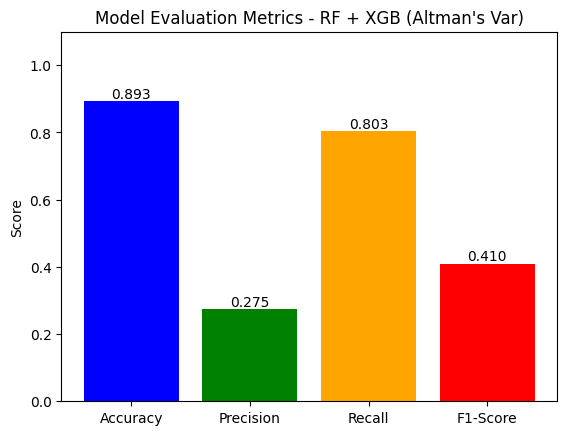

In [ ]:
eclf1 = VotingClassifier(estimators=[
    ('lr1', calibrated_log_reg),
    ('svc1', calibrated_svc_rbf_smote)
], voting='soft')


eclf1.fit(X_norm_train_smote, y_norm_train_smote)

print("Ensemble Model Evaluation:")
evaluate_model(eclf1, X_norm_test, y_norm_test)

visua_evaluate_model(eclf1, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "RF + XGB (Altman's Var)")

### **Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2420
           1       0.23      0.72      0.34       117

    accuracy                           0.87      2537
   macro avg       0.60      0.80      0.64      2537
weighted avg       0.95      0.87      0.90      2537



Training: 100%|██████████| 2/2 [01:23<00:00, 41.95s/it]


Accuracy: 0.873
Precision: 0.225
F1-Score: 0.343
Recall: 0.718


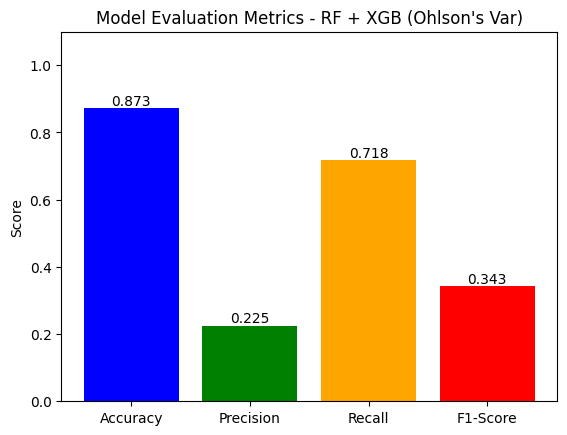

In [ ]:
eclf2 = VotingClassifier(estimators=[
    ('lr1', calibrated_log_reg2),
    ('svc_rbf', calibrated_svc_rbf_smote2)
], voting='soft')


eclf2.fit(X1_norm_train_smote, y1_norm_train_smote)

print("Ensemble Model Evaluation:")
evaluate_model(eclf2, X1_norm_test, y1_norm_test)

visua_evaluate_model(eclf2, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "RF + XGB (Ohlson's Var)")

### **Altman and Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2420
           1       0.28      0.85      0.42       117

    accuracy                           0.89      2537
   macro avg       0.64      0.87      0.68      2537
weighted avg       0.96      0.89      0.92      2537



Training: 100%|██████████| 2/2 [01:13<00:00, 36.87s/it]


Accuracy: 0.893
Precision: 0.280
F1-Score: 0.421
Recall: 0.846


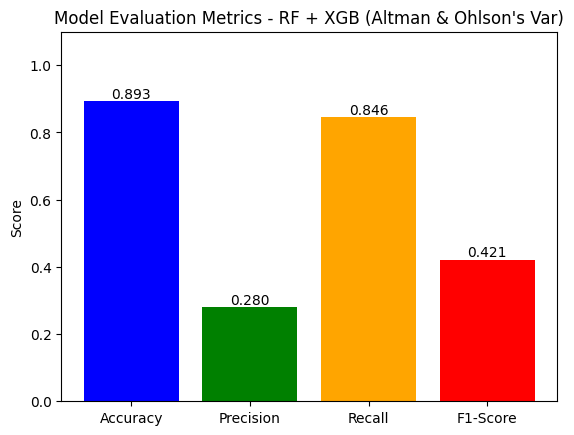

In [ ]:
eclf3 = VotingClassifier(estimators=[
    ('lr1', calibrated_log_reg3),
    ('svc_rbf', calibrated_svc_rbf_smote3)
], voting='soft')


eclf3.fit(X2_norm_train_smote, y2_norm_train_smote)

print("Ensemble Model Evaluation:")
evaluate_model(eclf3, X2_norm_test, y2_norm_test)

visua_evaluate_model(eclf3, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "RF + XGB (Altman & Ohlson's Var)")

### **LR + RF**

### **Altman's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2420
           1       0.49      0.83      0.62       117

    accuracy                           0.95      2537
   macro avg       0.74      0.89      0.80      2537
weighted avg       0.97      0.95      0.96      2537



Training: 100%|██████████| 2/2 [00:31<00:00, 15.67s/it]


Accuracy: 0.953
Precision: 0.492
F1-Score: 0.618
Recall: 0.829


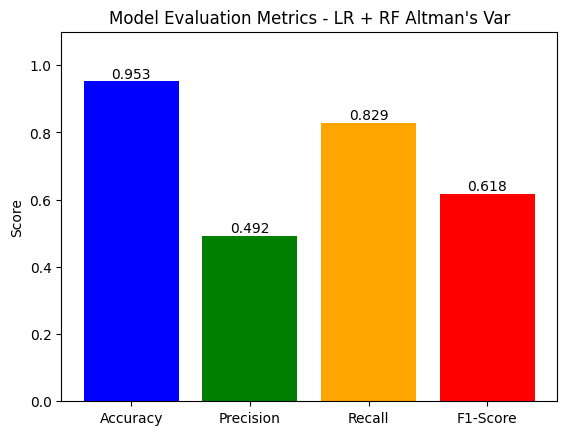

In [ ]:
eclf4 = VotingClassifier(estimators=[
    ('lr1', calibrated_log_reg),
    ('rf1', calibrated_rf_smote)
], voting='soft')


eclf4.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf4, X_norm_test, y_norm_test)


visua_evaluate_model(eclf4, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "LR + RF Altman's Var")

### **Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2420
           1       0.44      0.75      0.56       117

    accuracy                           0.94      2537
   macro avg       0.71      0.85      0.76      2537
weighted avg       0.96      0.94      0.95      2537



Training: 100%|██████████| 2/2 [00:41<00:00, 20.63s/it]


Accuracy: 0.945
Precision: 0.442
F1-Score: 0.557
Recall: 0.752


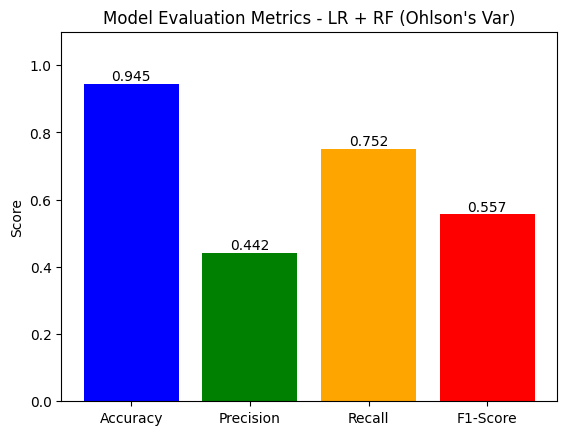

In [ ]:
eclf5 = VotingClassifier(estimators=[
    ('lr2', calibrated_log_reg2),
    ('rf2', calibrated_rf_smote2)
], voting='soft')


eclf5.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf5, X1_norm_test, y1_norm_test)

visua_evaluate_model(eclf5, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "LR + RF (Ohlson's Var)")

### **Altman and Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2420
           1       0.52      0.82      0.64       117

    accuracy                           0.96      2537
   macro avg       0.76      0.89      0.81      2537
weighted avg       0.97      0.96      0.96      2537



Training: 100%|██████████| 2/2 [00:41<00:00, 20.83s/it]


Accuracy: 0.957
Precision: 0.522
F1-Score: 0.638
Recall: 0.821


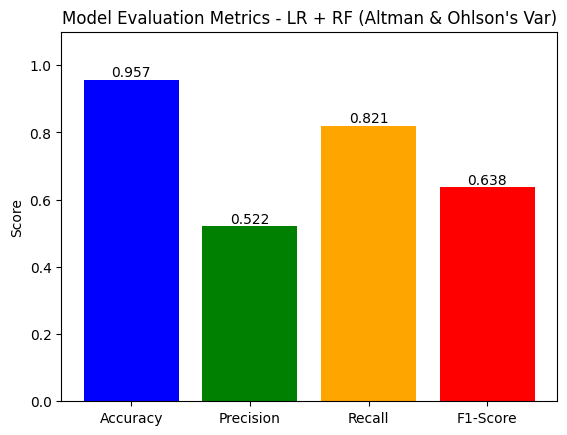

In [ ]:
eclf6 = VotingClassifier(estimators=[
    ('lr3', calibrated_log_reg3),
    ('rf3', calibrated_rf_smote3)
], voting='soft')

eclf6.fit(X2_norm_train_smote, y2_norm_train_smote)

# In ra đánh giá của ensemble model
print("Ensemble Model Evaluation:")
evaluate_model(eclf6, X2_norm_test, y2_norm_test)

# Visualize evaluation
visua_evaluate_model(eclf6, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "LR + RF (Altman & Ohlson's Var)")


### **LR + DT**

### **Altman's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2420
           1       0.42      0.81      0.55       117

    accuracy                           0.94      2537
   macro avg       0.70      0.88      0.76      2537
weighted avg       0.96      0.94      0.95      2537



Training: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Accuracy: 0.939
Precision: 0.419
F1-Score: 0.552
Recall: 0.812


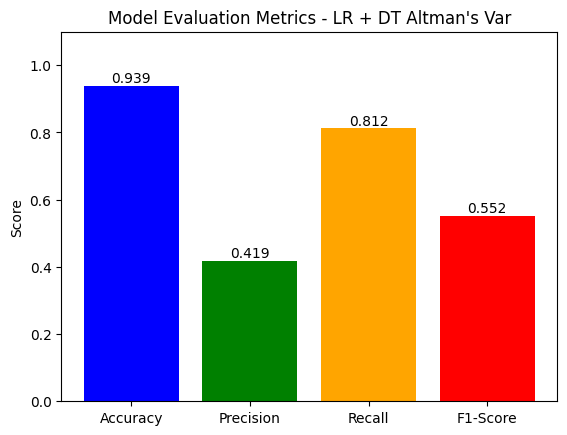

In [ ]:
eclf7 = VotingClassifier(estimators=[
    ('lr1', calibrated_log_reg),
    ('dt1', calibrated_dt_smote)
], voting='soft')


eclf7.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf7, X_norm_test, y_norm_test)


visua_evaluate_model(eclf7, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "LR + DT Altman's Var")

### **Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2420
           1       0.39      0.77      0.52       117

    accuracy                           0.93      2537
   macro avg       0.69      0.86      0.74      2537
weighted avg       0.96      0.93      0.94      2537



Training: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Accuracy: 0.935
Precision: 0.395
F1-Score: 0.522
Recall: 0.769


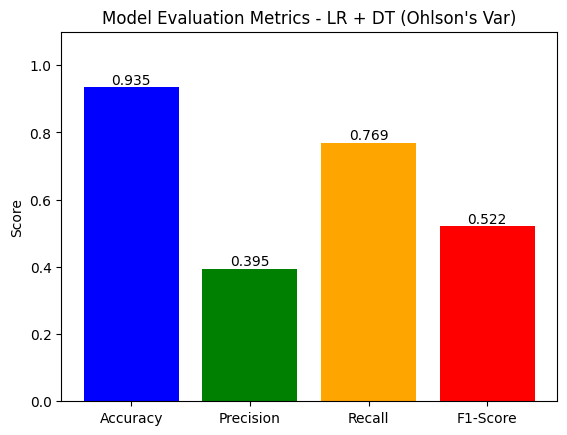

In [ ]:
eclf8 = VotingClassifier(estimators=[
    ('lr2', calibrated_log_reg2),
    ('dt2', calibrated_dt_smote2)
], voting='soft')


eclf8.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf8, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf8, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "LR + DT (Ohlson's Var)")

### **Altman and Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2420
           1       0.44      0.83      0.58       117

    accuracy                           0.94      2537
   macro avg       0.72      0.89      0.77      2537
weighted avg       0.97      0.94      0.95      2537



Training: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


Accuracy: 0.944
Precision: 0.443
F1-Score: 0.577
Recall: 0.829


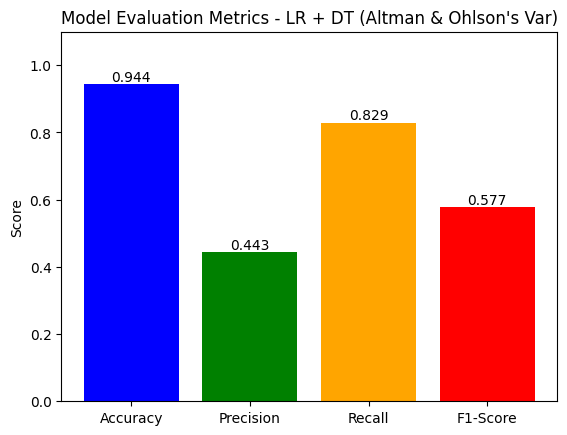

In [ ]:
eclf9 = VotingClassifier(estimators=[
    ('lr3', calibrated_log_reg3),
    ('dt3', calibrated_dt_smote3)
], voting='soft')


eclf9.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf9, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf9, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "LR + DT (Altman & Ohlson's Var)")

### **LR + XGB**

### **Altman's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2420
           1       0.44      0.82      0.58       117

    accuracy                           0.94      2537
   macro avg       0.72      0.89      0.77      2537
weighted avg       0.97      0.94      0.95      2537



Training: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


Accuracy: 0.944
Precision: 0.444
F1-Score: 0.577
Recall: 0.821


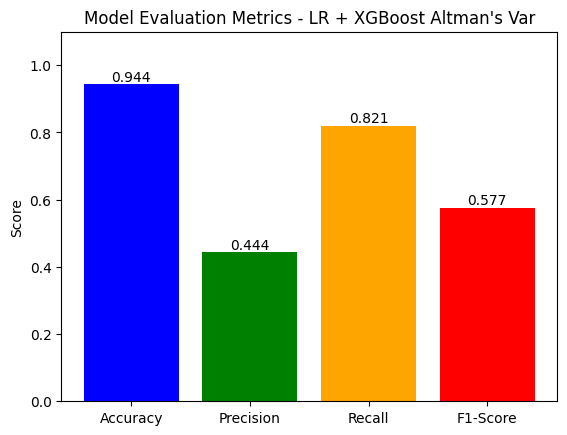

In [ ]:
eclf10 = VotingClassifier(estimators=[
    ('lr1', calibrated_log_reg),
    ('xgb1', calibrated_xgb_smote)
], voting='soft')


eclf10.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf10, X_norm_test, y_norm_test)


visua_evaluate_model(eclf10, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "LR + XGBoost Altman's Var")

### **Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2420
           1       0.42      0.74      0.54       117

    accuracy                           0.94      2537
   macro avg       0.70      0.85      0.75      2537
weighted avg       0.96      0.94      0.95      2537



Training: 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Accuracy: 0.941
Precision: 0.420
F1-Score: 0.537
Recall: 0.744


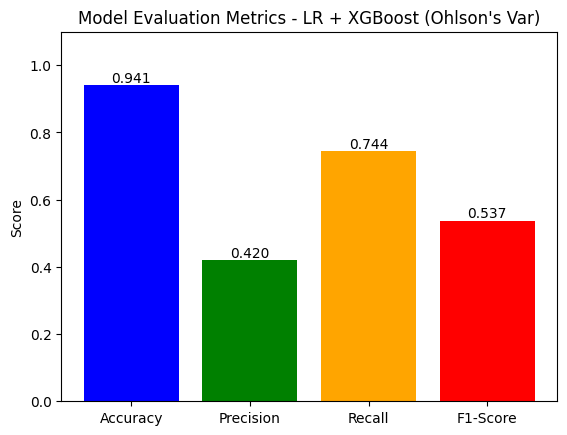

In [ ]:
eclf11 = VotingClassifier(estimators=[
    ('lr2', calibrated_log_reg2),
    ('xgb2', calibrated_xgb_smote2)
], voting='soft')


eclf11.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf11, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf11, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "LR + XGBoost (Ohlson's Var)")

### **Altman and Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2420
           1       0.54      0.80      0.64       117

    accuracy                           0.96      2537
   macro avg       0.76      0.88      0.81      2537
weighted avg       0.97      0.96      0.96      2537



Training: 100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


Accuracy: 0.959
Precision: 0.537
F1-Score: 0.644
Recall: 0.803


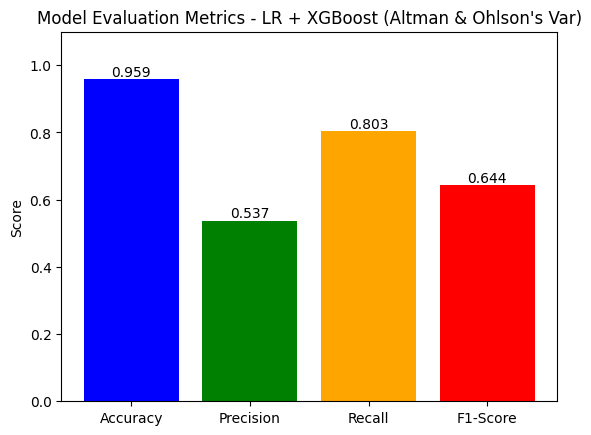

In [ ]:
eclf12 = VotingClassifier(estimators=[
    ('lr3', calibrated_log_reg3),
    ('xgb3', calibrated_xgb_smote3)
], voting='soft')


eclf12.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf12, X2_norm_test, y2_norm_test)

visua_evaluate_model(eclf12, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "LR + XGBoost (Altman & Ohlson's Var)")

### **LR + LGBM**

### **Altman's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training:  50%|█████     | 1/2 [00:01<00:01,  1.58s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


Accuracy: 0.936
Precision: 0.403
F1-Score: 0.541
Recall: 0.821


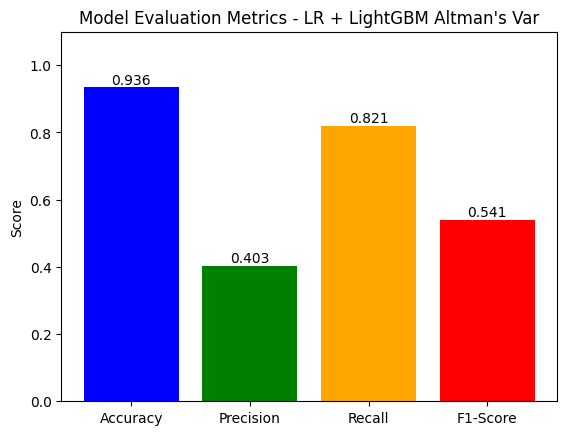

In [ ]:
eclf13 = VotingClassifier(estimators=[
    ('lr1', calibrated_log_reg),
    ('lgbm1', calibrated_lgb_smote)
], voting='soft')


eclf13.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf13, X_norm_test, y_norm_test)


visua_evaluate_model(eclf13, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "LR + LightGBM Altman's Var")

### **Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training:  50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


Accuracy: 0.930
Precision: 0.377
F1-Score: 0.511
Recall: 0.795


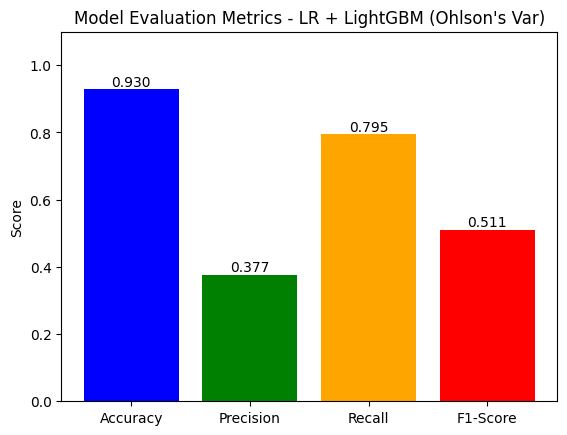

In [ ]:
eclf14 = VotingClassifier(estimators=[
    ('lr2', calibrated_log_reg2),
    ('lgbm2', calibrated_lgb_smote2)
], voting='soft')


eclf14.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf14, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf14, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "LR + LightGBM (Ohlson's Var)")

### **Altman and Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative

Training:  50%|█████     | 1/2 [00:02<00:02,  3.00s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative

Training: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


Accuracy: 0.950
Precision: 0.475
F1-Score: 0.599
Recall: 0.812


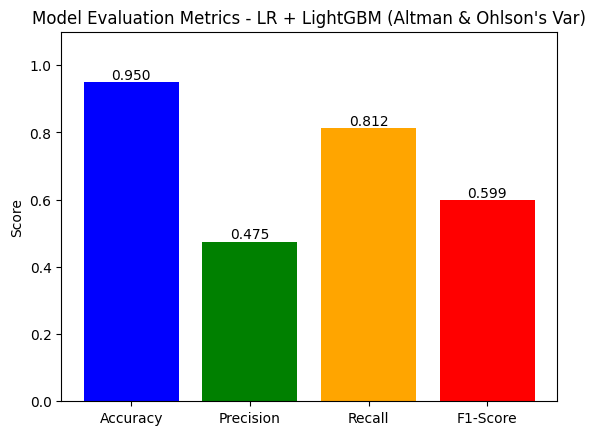

In [ ]:
eclf15 = VotingClassifier(estimators=[
    ('lr3', calibrated_log_reg3),
    ('lgbm3', calibrated_lgb_smote3)
], voting='soft')


eclf15.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf15, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf15, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "LR + LightGBM (Altman & Ohlson's Var)")

### **SVM + RF**

### **Altman's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2420
           1       0.43      0.79      0.56       117

    accuracy                           0.94      2537
   macro avg       0.71      0.87      0.76      2537
weighted avg       0.96      0.94      0.95      2537



Training: 100%|██████████| 2/2 [01:38<00:00, 49.19s/it]


Accuracy: 0.942
Precision: 0.431
F1-Score: 0.559
Recall: 0.795


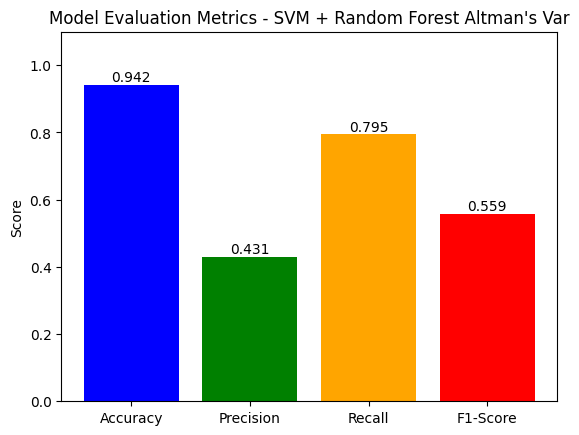

In [ ]:
eclf16 = VotingClassifier(estimators=[
    ('svc1', calibrated_svc_smote),
    ('rf1', calibrated_rf_smote)
], voting='soft')


eclf16.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf16, X_norm_test, y_norm_test)


visua_evaluate_model(eclf16, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "SVM + Random Forest Altman's Var")

### **Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2420
           1       0.43      0.75      0.55       117

    accuracy                           0.94      2537
   macro avg       0.71      0.85      0.76      2537
weighted avg       0.96      0.94      0.95      2537



Training: 100%|██████████| 2/2 [02:03<00:00, 61.93s/it]


Accuracy: 0.943
Precision: 0.431
F1-Score: 0.548
Recall: 0.752


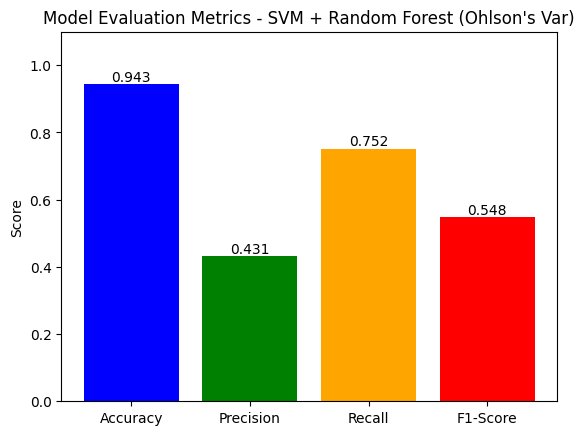

In [ ]:
eclf17 = VotingClassifier(estimators=[
    ('svc2', calibrated_svc_smote2),
    ('rf2', calibrated_rf_smote2)
], voting='soft')


eclf17.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf17, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf17, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "SVM + Random Forest (Ohlson's Var)")

### **Altman and Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2420
           1       0.52      0.83      0.64       117

    accuracy                           0.96      2537
   macro avg       0.76      0.90      0.81      2537
weighted avg       0.97      0.96      0.96      2537



Training: 100%|██████████| 2/2 [01:50<00:00, 55.22s/it]


Accuracy: 0.957
Precision: 0.519
F1-Score: 0.638
Recall: 0.829


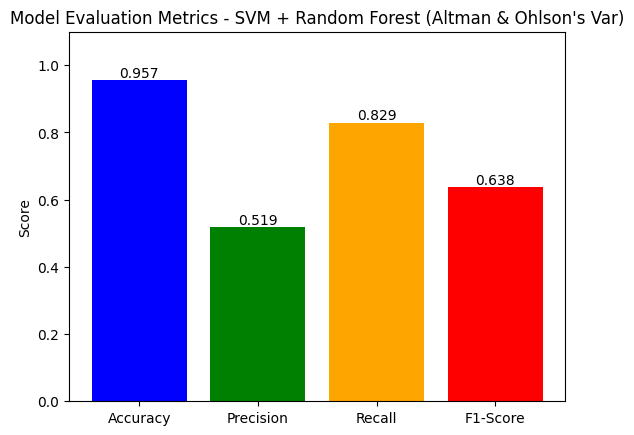

In [ ]:
eclf18 = VotingClassifier(estimators=[
    ('svc3', calibrated_svc_smote3),
    ('rf3', calibrated_rf_smote3)
], voting='soft')


eclf18.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf18, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf18, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "SVM + Random Forest (Altman & Ohlson's Var)")

### **SVM + DT**

### **Altman's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2420
           1       0.38      0.82      0.52       117

    accuracy                           0.93      2537
   macro avg       0.69      0.88      0.74      2537
weighted avg       0.96      0.93      0.94      2537



Training: 100%|██████████| 2/2 [01:10<00:00, 35.20s/it]


Accuracy: 0.930
Precision: 0.381
F1-Score: 0.520
Recall: 0.821


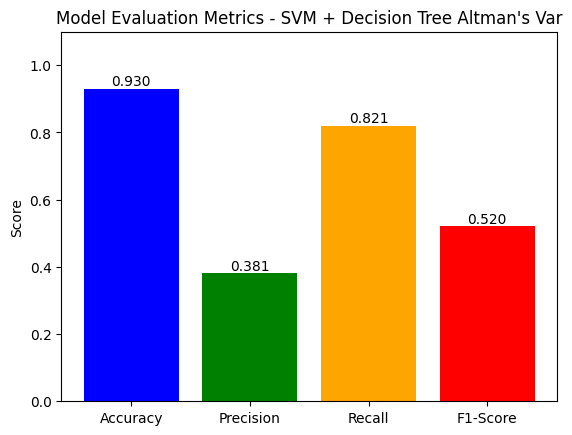

In [ ]:
eclf19 = VotingClassifier(estimators=[
    ('svc1', calibrated_svc_smote),
    ('dt1', calibrated_dt_smote)
], voting='soft')


eclf19.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf19, X_norm_test, y_norm_test)


visua_evaluate_model(eclf19, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "SVM + Decision Tree Altman's Var")


### **Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2420
           1       0.39      0.76      0.51       117

    accuracy                           0.93      2537
   macro avg       0.69      0.85      0.74      2537
weighted avg       0.96      0.93      0.94      2537



Training: 100%|██████████| 2/2 [01:25<00:00, 42.51s/it]


Accuracy: 0.933
Precision: 0.387
F1-Score: 0.513
Recall: 0.761


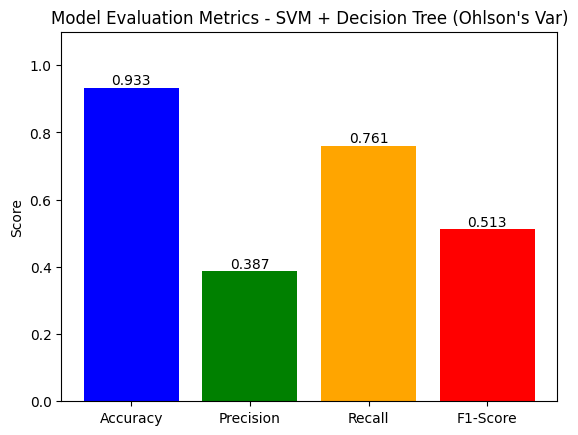

In [ ]:
eclf20 = VotingClassifier(estimators=[
    ('svc2', calibrated_svc_smote2),
    ('dt2', calibrated_dt_smote2)
], voting='soft')


eclf20.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf20, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf20, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "SVM + Decision Tree (Ohlson's Var)")


### **Altman and Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2420
           1       0.41      0.80      0.54       117

    accuracy                           0.94      2537
   macro avg       0.70      0.87      0.75      2537
weighted avg       0.96      0.94      0.95      2537



Training: 100%|██████████| 2/2 [01:14<00:00, 37.26s/it]


Accuracy: 0.938
Precision: 0.410
F1-Score: 0.543
Recall: 0.803


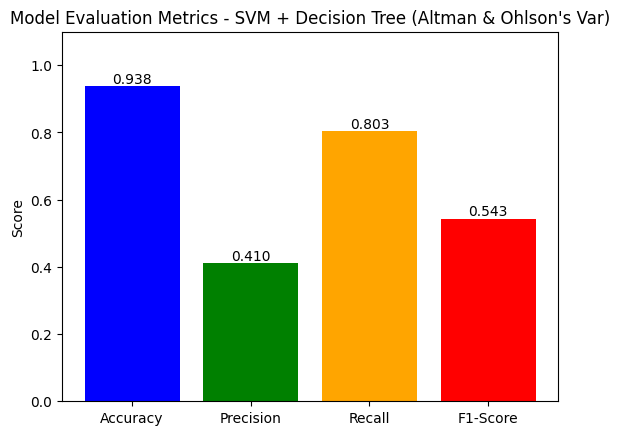

In [ ]:
eclf21 = VotingClassifier(estimators=[
    ('svc3', calibrated_svc_smote3),
    ('dt3', calibrated_dt_smote3)
], voting='soft')


eclf21.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf21, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf21, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "SVM + Decision Tree (Altman & Ohlson's Var)")


### **SVM + XGB**

### **Altman's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2420
           1       0.39      0.79      0.52       117

    accuracy                           0.93      2537
   macro avg       0.69      0.87      0.74      2537
weighted avg       0.96      0.93      0.94      2537



Training: 100%|██████████| 2/2 [01:09<00:00, 34.66s/it]


Accuracy: 0.933
Precision: 0.389
F1-Score: 0.522
Recall: 0.795


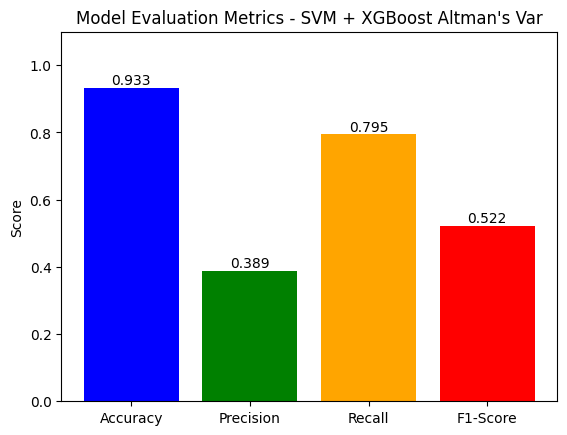

In [ ]:
eclf22 = VotingClassifier(estimators=[
    ('svc1', calibrated_svc_smote),
    ('xgb1', calibrated_xgb_smote)
], voting='soft')


eclf22.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf22, X_norm_test, y_norm_test)


visua_evaluate_model(eclf22, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "SVM + XGBoost Altman's Var")

### **Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2420
           1       0.41      0.74      0.52       117

    accuracy                           0.94      2537
   macro avg       0.70      0.84      0.74      2537
weighted avg       0.96      0.94      0.95      2537



Training: 100%|██████████| 2/2 [01:24<00:00, 42.45s/it]


Accuracy: 0.938
Precision: 0.406
F1-Score: 0.523
Recall: 0.735


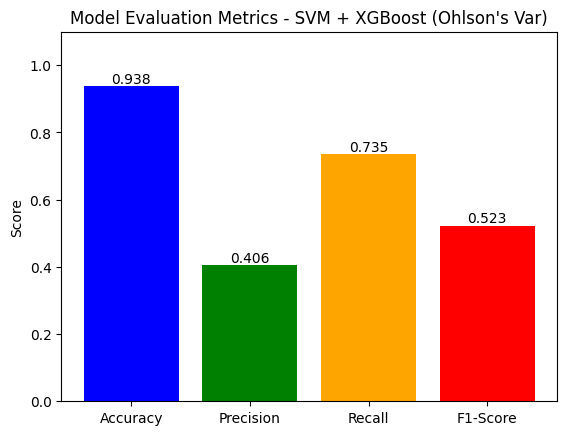

In [ ]:
eclf23 = VotingClassifier(estimators=[
    ('svc2', calibrated_svc_smote2),
    ('xgb2', calibrated_xgb_smote2)
], voting='soft')


eclf23.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf23, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf23, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "SVM + XGBoost (Ohlson's Var)")

### **Altman and Ohlson's Variables**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2420
           1       0.53      0.82      0.65       117

    accuracy                           0.96      2537
   macro avg       0.76      0.89      0.81      2537
weighted avg       0.97      0.96      0.96      2537



Training: 100%|██████████| 2/2 [01:15<00:00, 37.54s/it]


Accuracy: 0.959
Precision: 0.533
F1-Score: 0.646
Recall: 0.821


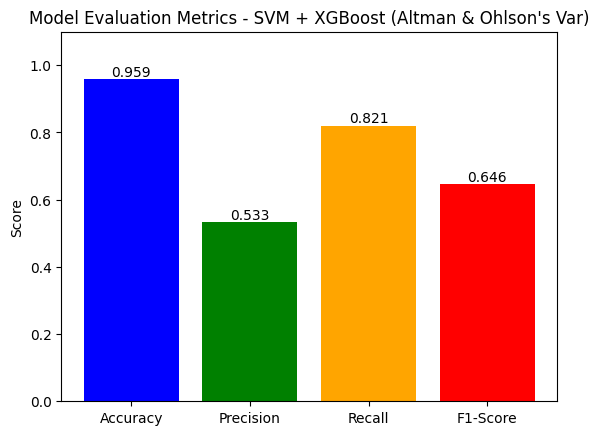

In [ ]:
eclf24 = VotingClassifier(estimators=[
    ('svc3', calibrated_svc_smote3),
    ('xgb3', calibrated_xgb_smote3)
], voting='soft')


eclf24.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf24, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf24, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "SVM + XGBoost (Altman & Ohlson's Var)")

### **SVM + LGBM**

### **Altman's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, t

Training:  50%|█████     | 1/2 [00:35<00:35, 35.48s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training: 100%|██████████| 2/2 [01:11<00:00, 35.67s/it]


Accuracy: 0.928
Precision: 0.376
F1-Score: 0.521
Recall: 0.846


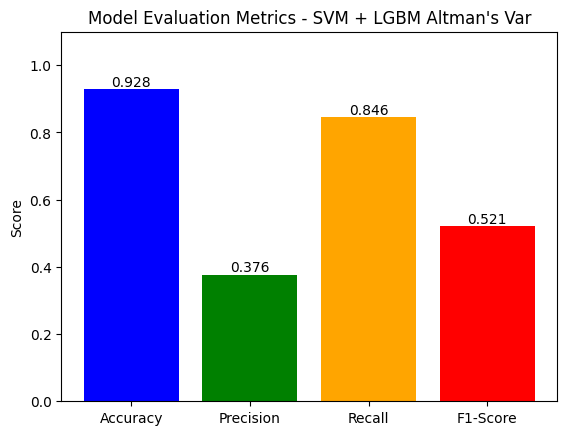

In [ ]:
eclf25 = VotingClassifier(estimators=[
    ('svc1', calibrated_svc_smote),
    ('lgbm1', calibrated_lgb_smote)
], voting='soft')


eclf25.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf25, X_norm_test, y_norm_test)


visua_evaluate_model(eclf25, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "SVM + LGBM Altman's Var")

### **Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training:  50%|█████     | 1/2 [00:43<00:43, 43.72s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training: 100%|██████████| 2/2 [01:25<00:00, 42.91s/it]


Accuracy: 0.927
Precision: 0.367
F1-Score: 0.504
Recall: 0.803


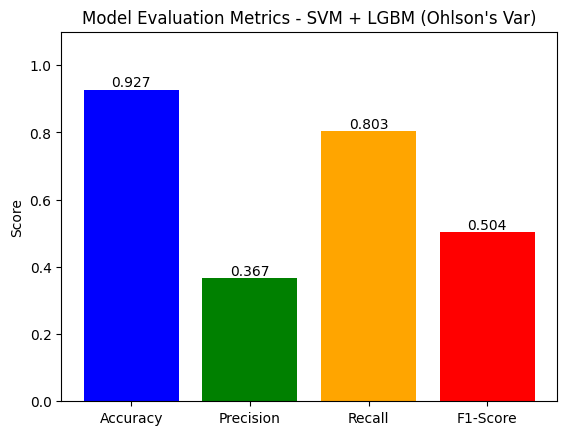

In [ ]:
eclf26 = VotingClassifier(estimators=[
    ('svc2', calibrated_svc_smote2),
    ('lgbm2', calibrated_lgb_smote2)
], voting='soft')


eclf26.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf26, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf26, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "SVM + LGBM (Ohlson's Var)")

### **Altman & Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training:  50%|█████     | 1/2 [00:36<00:36, 36.81s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training: 100%|██████████| 2/2 [01:15<00:00, 37.55s/it]


Accuracy: 0.950
Precision: 0.478
F1-Score: 0.609
Recall: 0.838


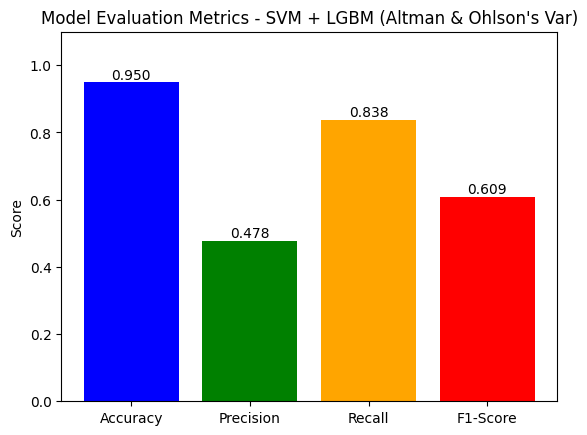

In [ ]:
eclf27 = VotingClassifier(estimators=[
    ('svc3', calibrated_svc_smote3),
    ('lgbm3', calibrated_lgb_smote3)
], voting='soft')


eclf27.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf27, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf27, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "SVM + LGBM (Altman & Ohlson's Var)")

### **RF + DT**

### **Altman's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2420
           1       0.45      0.72      0.55       117

    accuracy                           0.95      2537
   macro avg       0.72      0.84      0.76      2537
weighted avg       0.96      0.95      0.95      2537



Training: 100%|██████████| 2/2 [00:31<00:00, 15.51s/it]


Accuracy: 0.947
Precision: 0.452
F1-Score: 0.554
Recall: 0.718


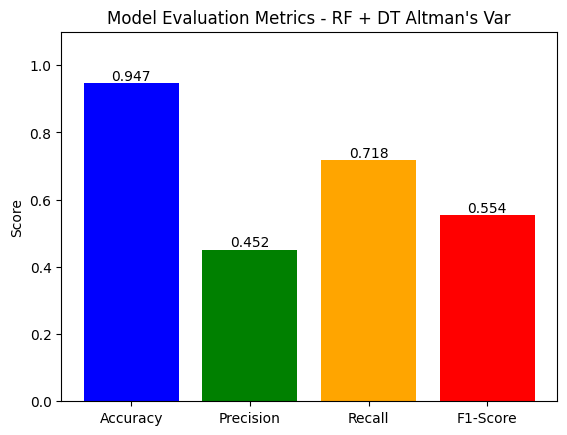

In [ ]:
eclf28 = VotingClassifier(estimators=[
    ('rf', calibrated_rf_smote),
    ('dt', calibrated_dt_smote)
], voting='soft')


eclf28.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf28, X_norm_test, y_norm_test)


visua_evaluate_model(eclf28, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "RF + DT Altman's Var")

### **Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2420
           1       0.44      0.64      0.52       117

    accuracy                           0.95      2537
   macro avg       0.71      0.80      0.75      2537
weighted avg       0.96      0.95      0.95      2537



Training: 100%|██████████| 2/2 [00:40<00:00, 20.19s/it]


Accuracy: 0.946
Precision: 0.439
F1-Score: 0.521
Recall: 0.641


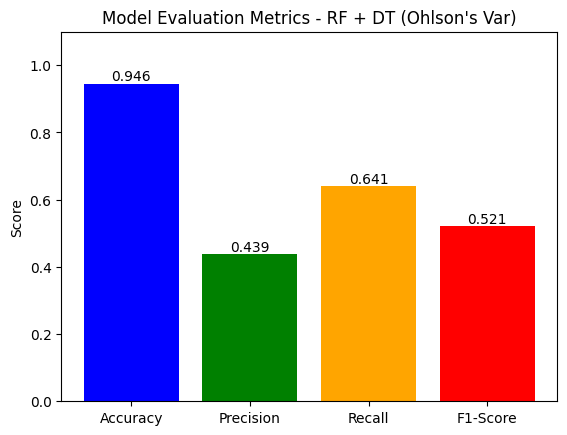

In [ ]:
eclf29 = VotingClassifier(estimators=[
    ('rf2', calibrated_rf_smote2),
    ('dt2', calibrated_dt_smote2)
], voting='soft')


eclf29.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf29, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf29, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "RF + DT (Ohlson's Var)")

### **Altman & Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2420
           1       0.58      0.70      0.64       117

    accuracy                           0.96      2537
   macro avg       0.78      0.84      0.81      2537
weighted avg       0.97      0.96      0.96      2537



Training: 100%|██████████| 2/2 [00:41<00:00, 20.55s/it]


Accuracy: 0.963
Precision: 0.582
F1-Score: 0.636
Recall: 0.701


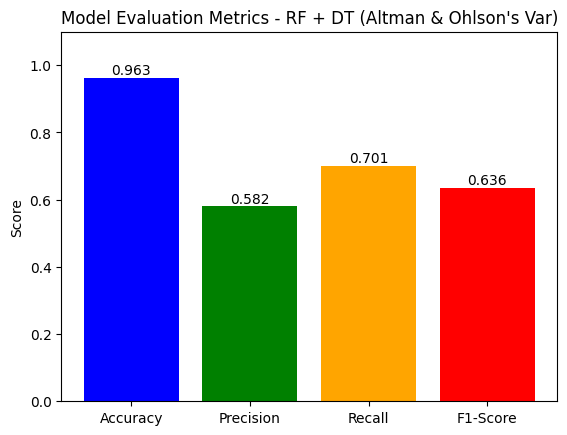

In [ ]:
eclf30 = VotingClassifier(estimators=[
    ('rf3', calibrated_rf_smote3),
    ('dt3', calibrated_dt_smote3)
], voting='soft')


eclf30.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf30, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf30, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "RF + DT (Altman & Ohlson's Var)")


### **RF + XGB**

### **Altman's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2420
           1       0.44      0.72      0.55       117

    accuracy                           0.95      2537
   macro avg       0.72      0.84      0.76      2537
weighted avg       0.96      0.95      0.95      2537



Training: 100%|██████████| 2/2 [00:33<00:00, 16.62s/it]


Accuracy: 0.946
Precision: 0.444
F1-Score: 0.549
Recall: 0.718


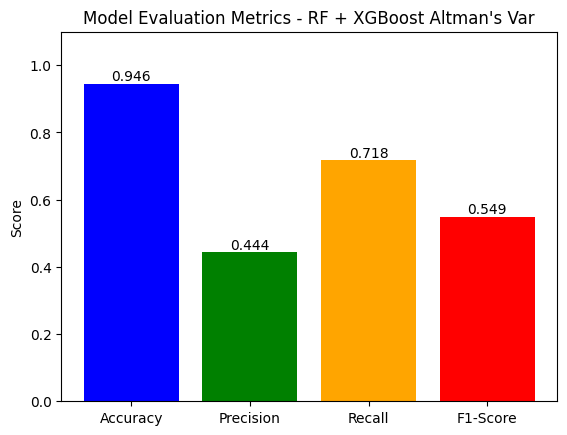

In [ ]:
eclf31 = VotingClassifier(estimators=[
    ('rf', calibrated_rf_smote),
    ('xgb', calibrated_xgb_smote)
], voting='soft')


eclf31.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf31, X_norm_test, y_norm_test)


visua_evaluate_model(eclf31, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "RF + XGBoost Altman's Var")

### **Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2420
           1       0.47      0.67      0.55       117

    accuracy                           0.95      2537
   macro avg       0.73      0.81      0.76      2537
weighted avg       0.96      0.95      0.95      2537



Training: 100%|██████████| 2/2 [00:41<00:00, 20.95s/it]


Accuracy: 0.950
Precision: 0.467
F1-Score: 0.549
Recall: 0.667


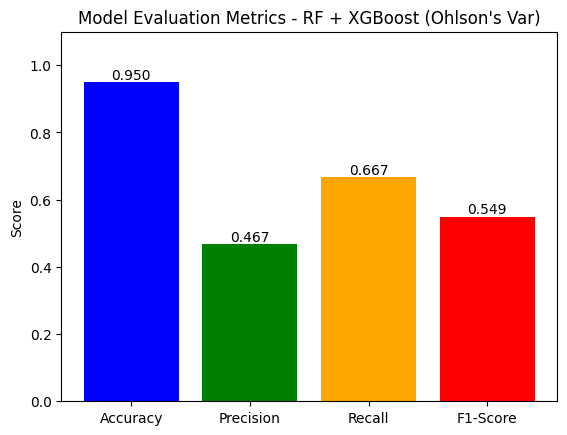

In [ ]:
eclf32 = VotingClassifier(estimators=[
    ('rf2', calibrated_rf_smote2),
    ('xgb2', calibrated_xgb_smote2)
], voting='soft')


eclf32.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf32, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf32, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "RF + XGBoost (Ohlson's Var)")

### **Altman & Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2420
           1       0.64      0.77      0.70       117

    accuracy                           0.97      2537
   macro avg       0.82      0.87      0.84      2537
weighted avg       0.97      0.97      0.97      2537



Training: 100%|██████████| 2/2 [00:43<00:00, 21.55s/it]


Accuracy: 0.970
Precision: 0.643
F1-Score: 0.700
Recall: 0.769


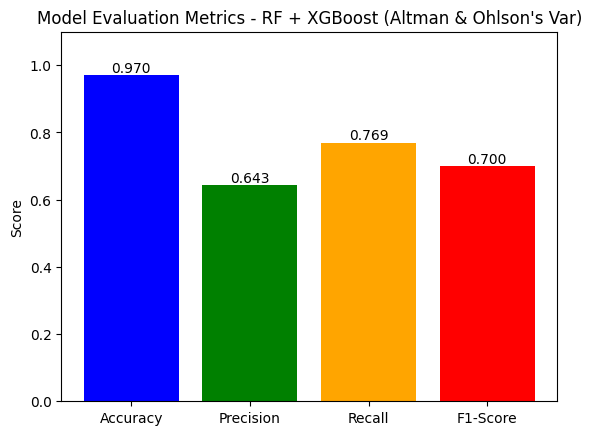

In [ ]:
eclf33 = VotingClassifier(estimators=[
    ('rf3', calibrated_rf_smote3),
    ('xgb3', calibrated_xgb_smote3)
], voting='soft')


eclf33.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf33, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf33, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "RF + XGBoost (Altman & Ohlson's Var)")

### **RF + LGBM**

### **Altman's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 

Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training:  50%|█████     | 1/2 [00:16<00:16, 16.28s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training: 100%|██████████| 2/2 [00:33<00:00, 16.63s/it]


Accuracy: 0.943
Precision: 0.433
F1-Score: 0.550
Recall: 0.752


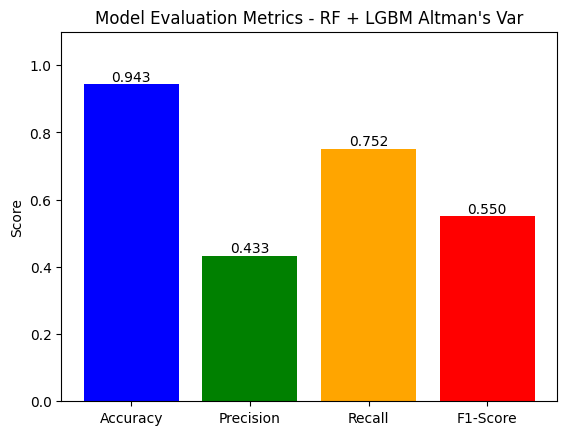

In [ ]:
eclf34 = VotingClassifier(estimators=[
    ('rf', calibrated_rf_smote),
    ('lgbm', calibrated_lgb_smote)
], voting='soft')


eclf34.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf34, X_norm_test, y_norm_test)


visua_evaluate_model(eclf34, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "RF + LGBM Altman's Var")

### **Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training:  50%|█████     | 1/2 [00:21<00:21, 21.99s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training: 100%|██████████| 2/2 [00:42<00:00, 21.23s/it]


Accuracy: 0.944
Precision: 0.429
F1-Score: 0.525
Recall: 0.675


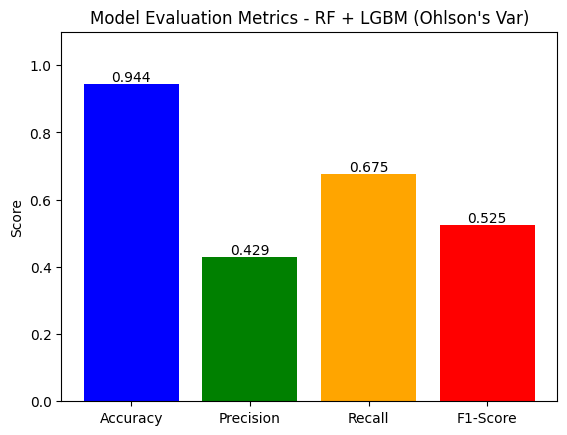

In [ ]:
eclf35 = VotingClassifier(estimators=[
    ('rf2', calibrated_rf_smote2),
    ('lgbm2', calibrated_lgb_smote2)
], voting='soft')


eclf35.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf35, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf35, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "RF + LGBM (Ohlson's Var)")

### **Altman & Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative

Training:  50%|█████     | 1/2 [00:22<00:22, 22.30s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training: 100%|██████████| 2/2 [00:43<00:00, 21.71s/it]


Accuracy: 0.967
Precision: 0.611
F1-Score: 0.684
Recall: 0.778


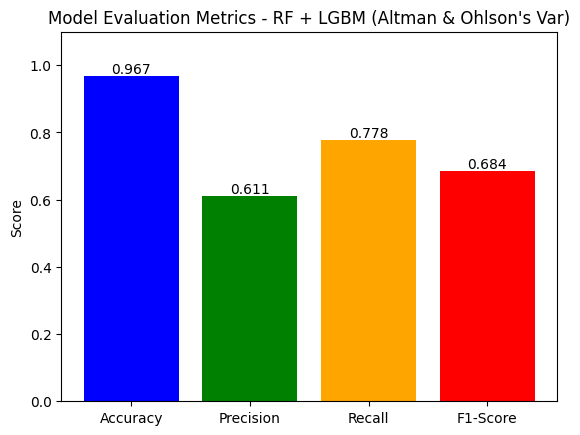

In [ ]:
eclf36 = VotingClassifier(estimators=[
    ('rf3', calibrated_rf_smote3),
    ('lgbm3', calibrated_lgb_smote3)
], voting='soft')


eclf36.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf36, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf36, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "RF + LGBM (Altman & Ohlson's Var)")

### **DT + XGB**

### **Altman's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2420
           1       0.44      0.74      0.55       117

    accuracy                           0.95      2537
   macro avg       0.72      0.85      0.76      2537
weighted avg       0.96      0.95      0.95      2537



Training: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


Accuracy: 0.945
Precision: 0.443
F1-Score: 0.553
Recall: 0.735


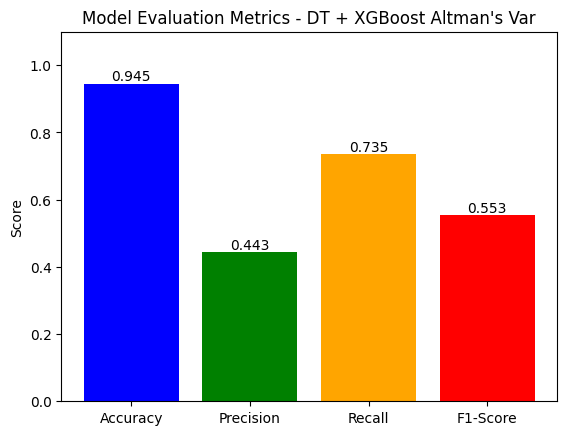

In [ ]:
eclf37 = VotingClassifier(estimators=[
    ('dt', calibrated_dt_smote),
    ('xgb', calibrated_xgb_smote)
], voting='soft')


eclf37.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf37, X_norm_test, y_norm_test)


visua_evaluate_model(eclf37, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "DT + XGBoost Altman's Var")

### **Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2420
           1       0.46      0.67      0.54       117

    accuracy                           0.95      2537
   macro avg       0.72      0.81      0.76      2537
weighted avg       0.96      0.95      0.95      2537



Training: 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


Accuracy: 0.948
Precision: 0.456
F1-Score: 0.542
Recall: 0.667


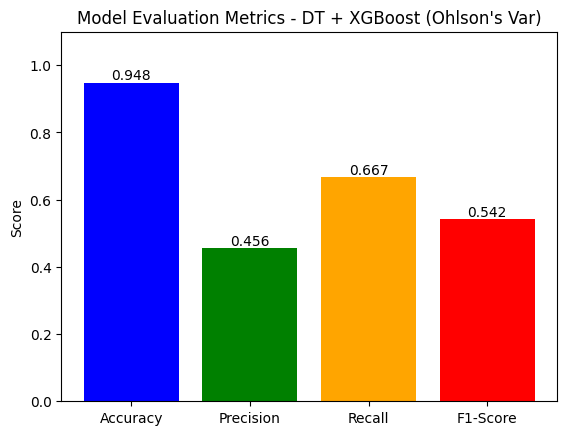

In [ ]:
eclf38 = VotingClassifier(estimators=[
    ('dt', calibrated_dt_smote2),
    ('xgb', calibrated_xgb_smote2)
], voting='soft')


eclf38.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf38, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf38, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "DT + XGBoost (Ohlson's Var)")

### **Altman & Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Ensemble Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2420
           1       0.60      0.74      0.67       117

    accuracy                           0.97      2537
   macro avg       0.80      0.86      0.82      2537
weighted avg       0.97      0.97      0.97      2537



Training: 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


Accuracy: 0.966
Precision: 0.604
F1-Score: 0.667
Recall: 0.744


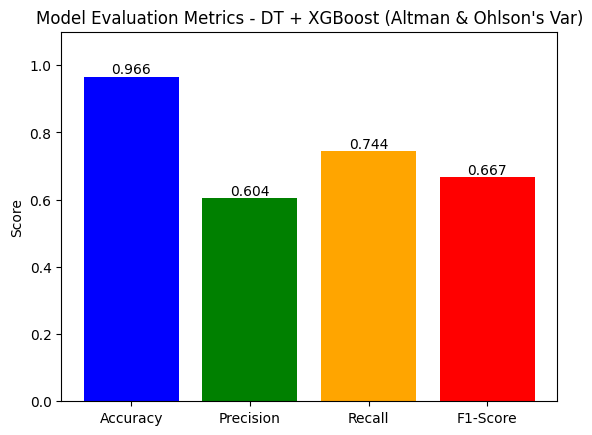

In [ ]:
eclf39 = VotingClassifier(estimators=[
    ('dt', calibrated_dt_smote3),
    ('xgb', calibrated_xgb_smote3)
], voting='soft')


eclf39.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf39, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf39, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "DT + XGBoost (Altman & Ohlson's Var)")

### **DT + LGBM**

### **Altman's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training:  50%|█████     | 1/2 [00:01<00:01,  1.97s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


Accuracy: 0.940
Precision: 0.418
F1-Score: 0.535
Recall: 0.744


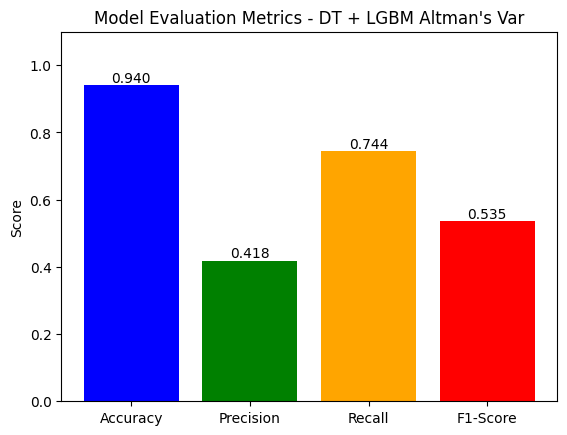

In [ ]:
eclf40 = VotingClassifier(estimators=[
    ('dt', calibrated_dt_smote),
    ('lgbm', calibrated_lgb_smote)
], voting='soft')


eclf40.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf40, X_norm_test, y_norm_test)


visua_evaluate_model(eclf40, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "DT + LGBM Altman's Var")

### **Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training:  50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training: 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Accuracy: 0.941
Precision: 0.418
F1-Score: 0.521
Recall: 0.692


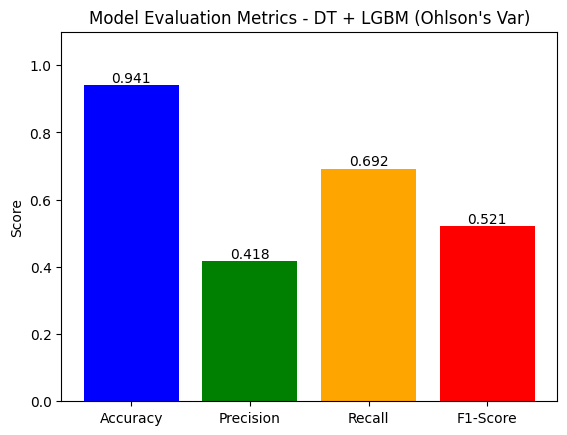

In [ ]:
eclf41 = VotingClassifier(estimators=[
    ('dt', calibrated_dt_smote2),
    ('lgbm', calibrated_lgb_smote2)
], voting='soft')


eclf41.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf41, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf41, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "DT + LGBM (Ohlson's Var)")

### **Altman & Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training:  50%|█████     | 1/2 [00:02<00:02,  2.91s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training: 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


Accuracy: 0.962
Precision: 0.563
F1-Score: 0.647
Recall: 0.761


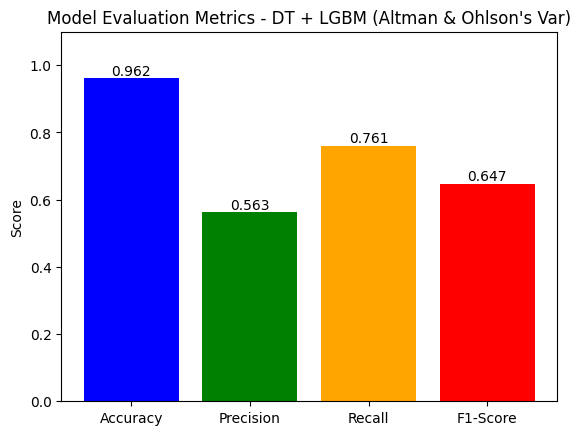

In [ ]:
eclf42 = VotingClassifier(estimators=[
    ('dt', calibrated_dt_smote3),
    ('lgbm', calibrated_lgb_smote3)
], voting='soft')


eclf42.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf42, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf42, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "DT + LGBM (Altman & Ohlson's Var)")

### **XGB + LGBM**

### **Altman's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training:  50%|█████     | 1/2 [00:03<00:03,  3.63s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

Training: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]


Accuracy: 0.939
Precision: 0.410
F1-Score: 0.533
Recall: 0.761


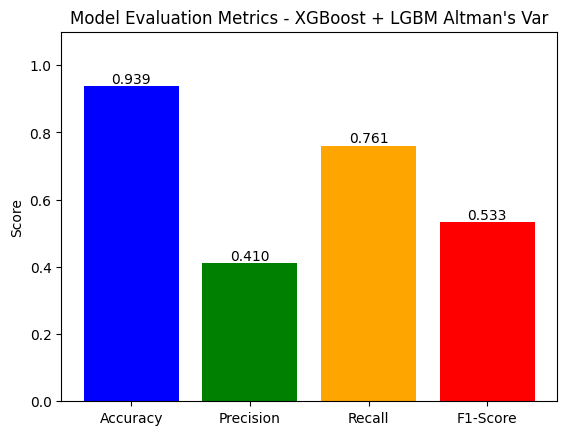

In [ ]:
eclf43 = VotingClassifier(estimators=[
    ('xgb', calibrated_xgb_smote),
    ('lgbm', calibrated_lgb_smote)
], voting='soft')


eclf43.fit(X_norm_train_smote, y_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf43, X_norm_test, y_norm_test)


visua_evaluate_model(eclf43, X_norm_train_smote, y_norm_train_smote.values.ravel(), X_norm_test, y_norm_test.values.ravel(), False, "XGBoost + LGBM Altman's Var")

### **Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training:  50%|█████     | 1/2 [00:03<00:03,  3.11s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training: 100%|██████████| 2/2 [00:06<00:00,  3.50s/it]


Accuracy: 0.940
Precision: 0.411
F1-Score: 0.516
Recall: 0.692


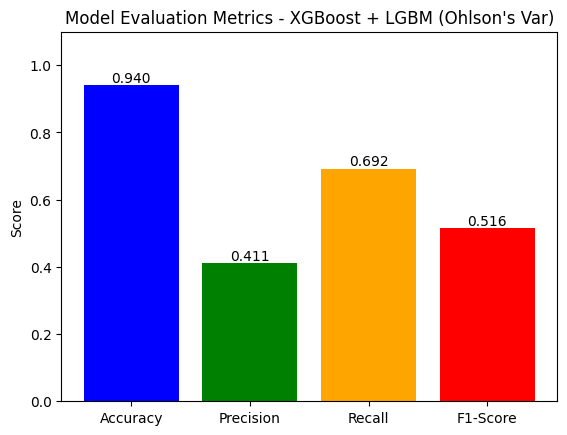

In [ ]:
eclf44 = VotingClassifier(estimators=[
    ('xgb', calibrated_xgb_smote2),
    ('lgbm', calibrated_lgb_smote2)
], voting='soft')


eclf44.fit(X1_norm_train_smote, y1_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf44, X1_norm_test, y1_norm_test)


visua_evaluate_model(eclf44, X1_norm_train_smote, y1_norm_train_smote.values.ravel(), X1_norm_test, y1_norm_test.values.ravel(), False, "XGBoost + LGBM (Ohlson's Var)")

### **Altman & Ohlson's Variales**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

Training:  50%|█████     | 1/2 [00:03<00:03,  3.30s/it]

[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 15574, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7787, number of negative: 7787
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

Training: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


Accuracy: 0.966
Precision: 0.597
F1-Score: 0.688
Recall: 0.812


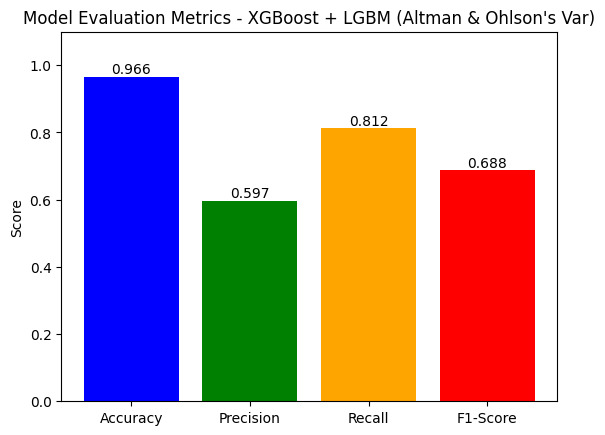

In [ ]:
eclf45 = VotingClassifier(estimators=[
    ('xgb', calibrated_xgb_smote3),
    ('lgbm', calibrated_lgb_smote3)
], voting='soft')


eclf45.fit(X2_norm_train_smote, y2_norm_train_smote)


print("Ensemble Model Evaluation:")
evaluate_model(eclf45, X2_norm_test, y2_norm_test)


visua_evaluate_model(eclf45, X2_norm_train_smote, y2_norm_train_smote.values.ravel(), X2_norm_test, y2_norm_test.values.ravel(), False, "XGBoost + LGBM (Altman & Ohlson's Var)")